Imports, loading data set, visualising data set, and setting up for analysis. The goal of this project is to utilize machine learning to devise meaningful ways of classifying or predicting arrythmic ECG signals.

In [98]:
import os
import glob
import re
import wfdb as wf
from wfdb import processing
import numpy as np
import pandas as pd
from collections import Counter
from numpy import matmul
from matplotlib import pyplot as plt
from scipy import signal
from scipy.sparse import identity
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
from scipy.signal import argrelextrema
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import train_test_split as TTS
from sklearn.utils import resample

samplenumber=100000    #sample size for analysis

filenames = glob.glob('DataFiles/*.dat') #reading files from DataFiles folder
pchannelb=[] #initiating arrays
file_nums=[]
pfreq=[]
recordall=[]
annall=[]
pchannel=[]

for i, s in enumerate(filenames):                 
    num_str = re.search("(\d+).dat",  filenames[i]) 
    file_nums.append(num_str.group(1)) #extracting the numbering system of the data files, saving them to an array for calling them in the future 
    
for j, k in enumerate(file_nums):
    record = wf.rdrecord('Datafiles/'+file_nums[j], sampto=samplenumber)
    pchannelb.append(record.p_signal[:,0])
    recordall.append(record)
    ann = wf.rdann('DataFiles/'+file_nums[j], 'atr', sampto=samplenumber) #reading the data and annotation files
    annall.append(ann)
    #wf.plot_wfdb(record=record, annotation = ann, title='Record '+file_nums[j]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,10)) #plotting all of the files

for l in range(len(pchannelb)):
    pchannel.append((pchannelb[l] - np.mean(pchannelb[l])) / np.std(pchannelb[l]))

Finding Peaks. This part utilizes the gqrs function in wfdb to find R peaks. Annotations inherent in the data serves the same purpose.

C:\Anaconda3\lib\site-packages\wfdb\processing\hr.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  hr = 60000.0 / rr


Example of Gqrs detected peak indices: [250, 472, 614, 867, 1081, 1298, 1586, 1818, 2029, 2249, 2508, 2749, 2987, 3246, 3464, 3674, 3914, 4151, 4381, 4595, 4825, 5124, 5362, 5631, 5828, 6092, 6363, 6596, 6740, 6947, 7186, 7414, 7617, 7842, 8193, 8399, 8668, 8876, 9103, 9416, 9677, 9899, 10248, 10498, 10749, 10952, 11152, 11427, 11670, 11923, 12167, 12376, 12586, 12789, 13016, 13201, 13452, 13723, 13977, 14197, 14450, 14667, 14953, 15185, 15413, 15642, 15874, 16125, 16351, 16606, 16845, 16996, 17259, 17521, 17786, 18053, 18258, 18513, 18747, 18977, 19168, 19355, 19555, 19767, 20033, 20274, 20511, 20692, 21047, 21246, 21444, 21638, 21840, 22083, 22356, 22618, 22876, 23184, 23438, 23691, 23938, 24193, 24431, 24700, 24967, 25193, 25390, 25518, 25846, 26103, 26309, 26515, 26780, 27111, 27365, 27580, 27826, 28098, 28332, 28619, 28886, 29135, 29413, 29661, 29909, 30204, 30448, 30683, 30955, 31150, 31424, 31636, 31916, 32151, 32340, 32552, 32805, 33083, 33337, 33605, 33870, 34130, 34379, 34606

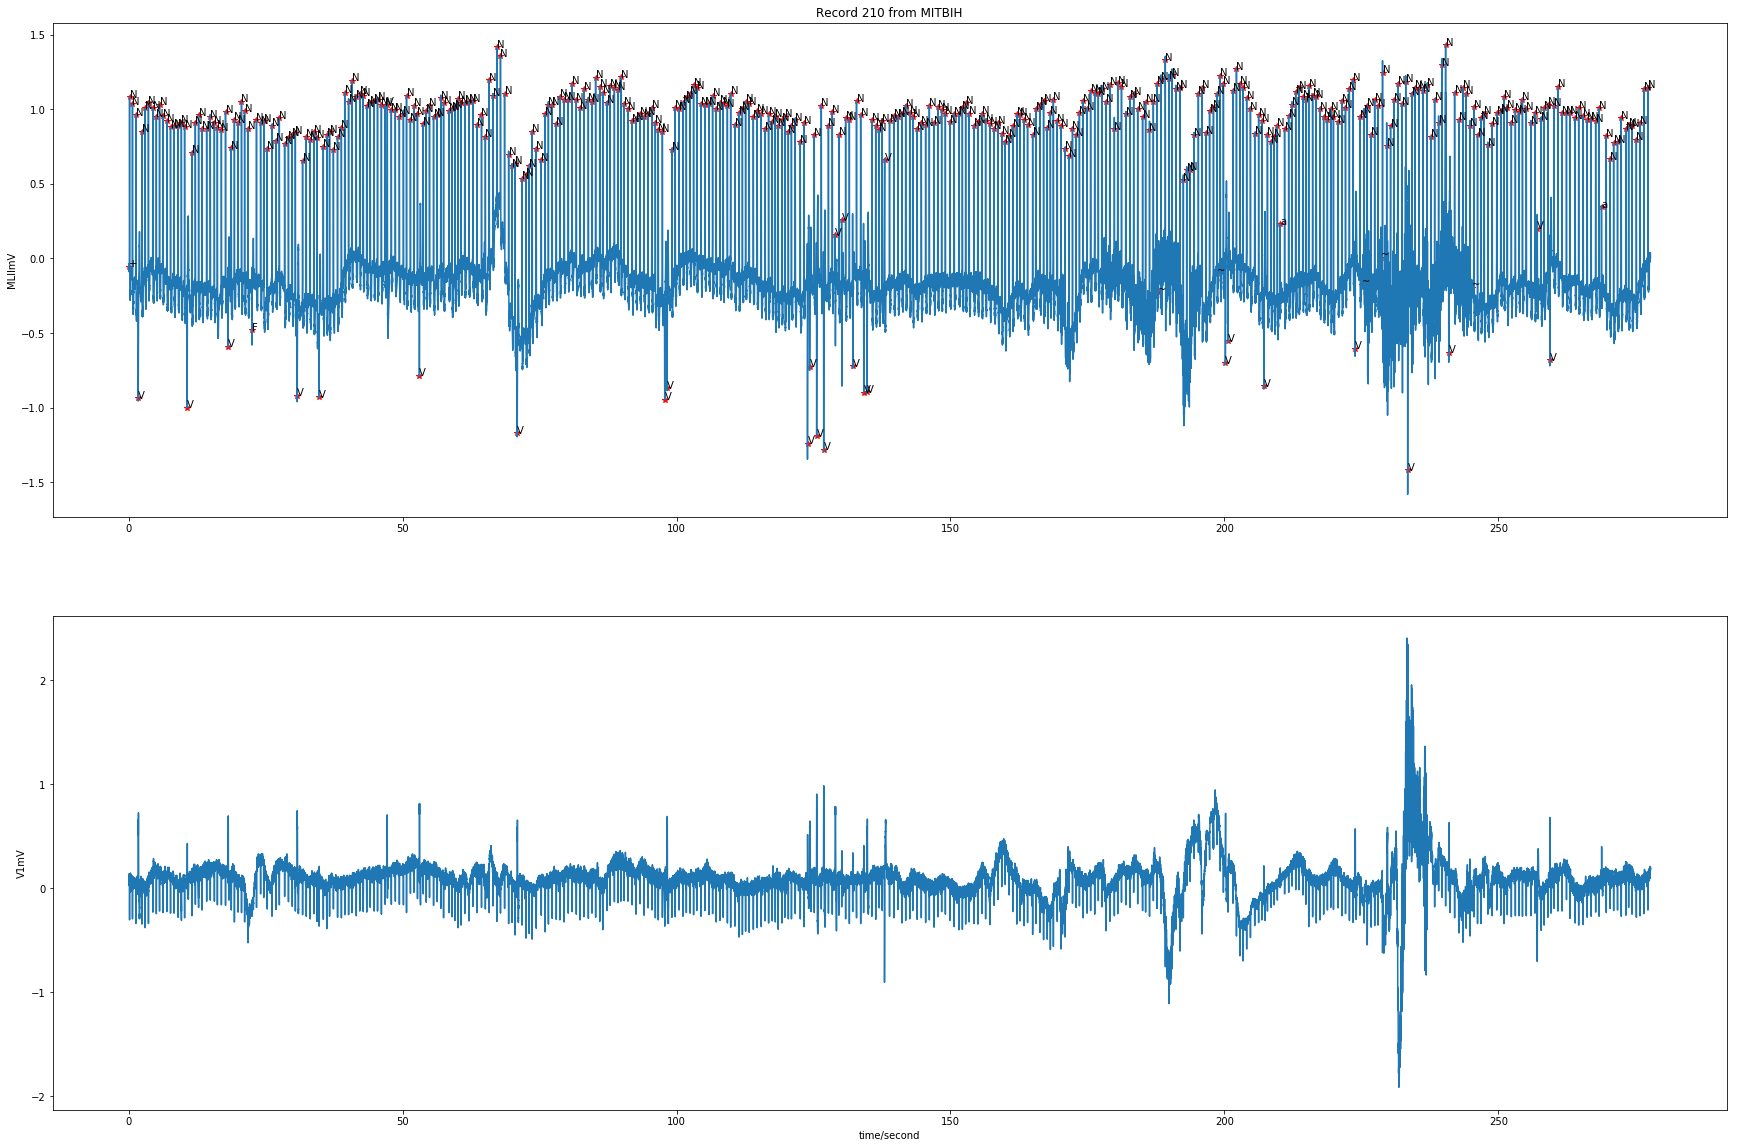

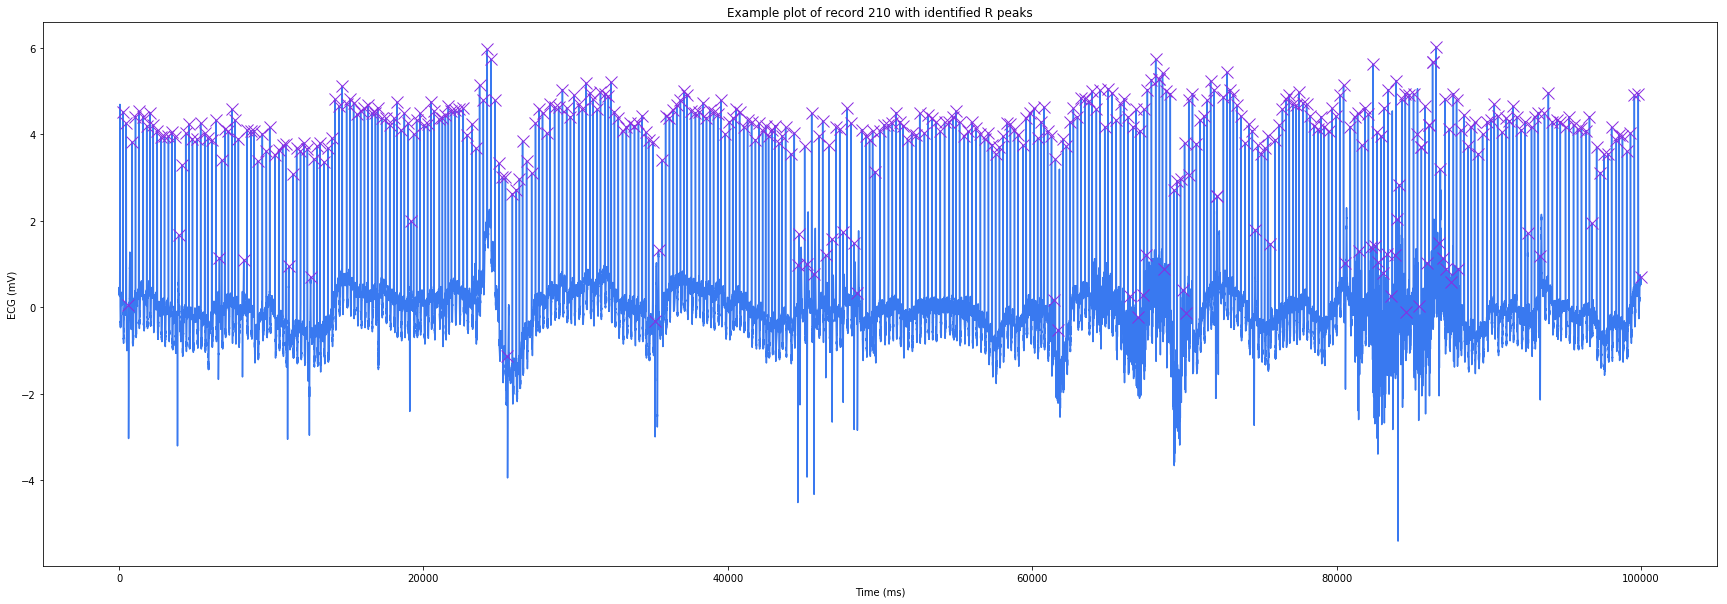

In [90]:
datanumb=31  #which data set to look at

# Use the gqrs algorithm to detect qrs locations in the first channel
search_radius=[]
qrs_inds=[]
peak_inds=[]
hrs=[]
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius

for i in range(len(recordall)):
    search_radius.append(int(recordall[i].fs * 60 / max_bpm))
    qrs_inds.append(processing.gqrs_detect(sig=pchannel[i], fs=recordall[i].fs))
    peak_inds.append(processing.correct_peaks(pchannel[i], peak_inds=qrs_inds[i], search_radius=search_radius[i], smooth_window_size=100))
    hrs.append(processing.compute_hr(sig_len=pchannel[i].shape[0], qrs_inds=peak_inds[i], fs=recordall[i].fs)) #find heart beat for later feature extraction

print('Example of Gqrs detected peak indices:', sorted(peak_inds[datanumb]))

wf.plot_wfdb(record=recordall[datanumb], annotation = annall[datanumb], title='Record '+file_nums[datanumb]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,20))
plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb], color='#3979f0', label='Signal')
plt.plot(peak_inds[datanumb], pchannel[datanumb][peak_inds[datanumb]], 'rx', marker='x', color='#8A2BE2', label='Peak', markersize=12)
plt.title('Example plot of record '+file_nums[datanumb]+' with identified R peaks')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')

Extracting features based on peak detection. This section finds meaningful maxima/minima outside of R peaks (such as P, Q, S, T). Features could be used for part A below.

[   13    57   250   471   625   866  1081  1298  1586  1818  2028  2249
  2508  2749  2987  3246  3464  3674  3841  4151  4381  4595  4825  5124
  5363  5631  5828  6092  6364  6531  6740  6947  7187  7414  7617  7842
  8115  8399  8669  8876  9103  9415  9678  9899 10247 10498 10750 10952
 11072 11427 11670 11923 12167 12376 12506 12789 13016 13201 13452 13723
 13977 14197 14449 14667 14954 15184 15413 15642 15874 16125 16352 16606
 16845 16998 17259 17521 17787 18054 18257 18513 18747 18977 19102 19355
 19555 19767 20034 20274 20510 20692 21047 21246 21444 21638 21840 22083
 22356 22618 22876 23184 23438 23691 23939 24193 24431 24700 24968 25192
 25390 25528 25846 26103 26308 26514 26779 27111 27365 27579 27826 28099
 28332 28619 28886 29135 29413 29661 29909 30205 30448 30683 30955 31150
 31423 31636 31916 32151 32340 32552 32805 33083 33338 33605 33870 34130
 34379 34606 34800 35070 35223 35373 35695 35914 36166 36419 36644 36888
 37120 37329 37611 37875 38133 38369 38602 38851 39

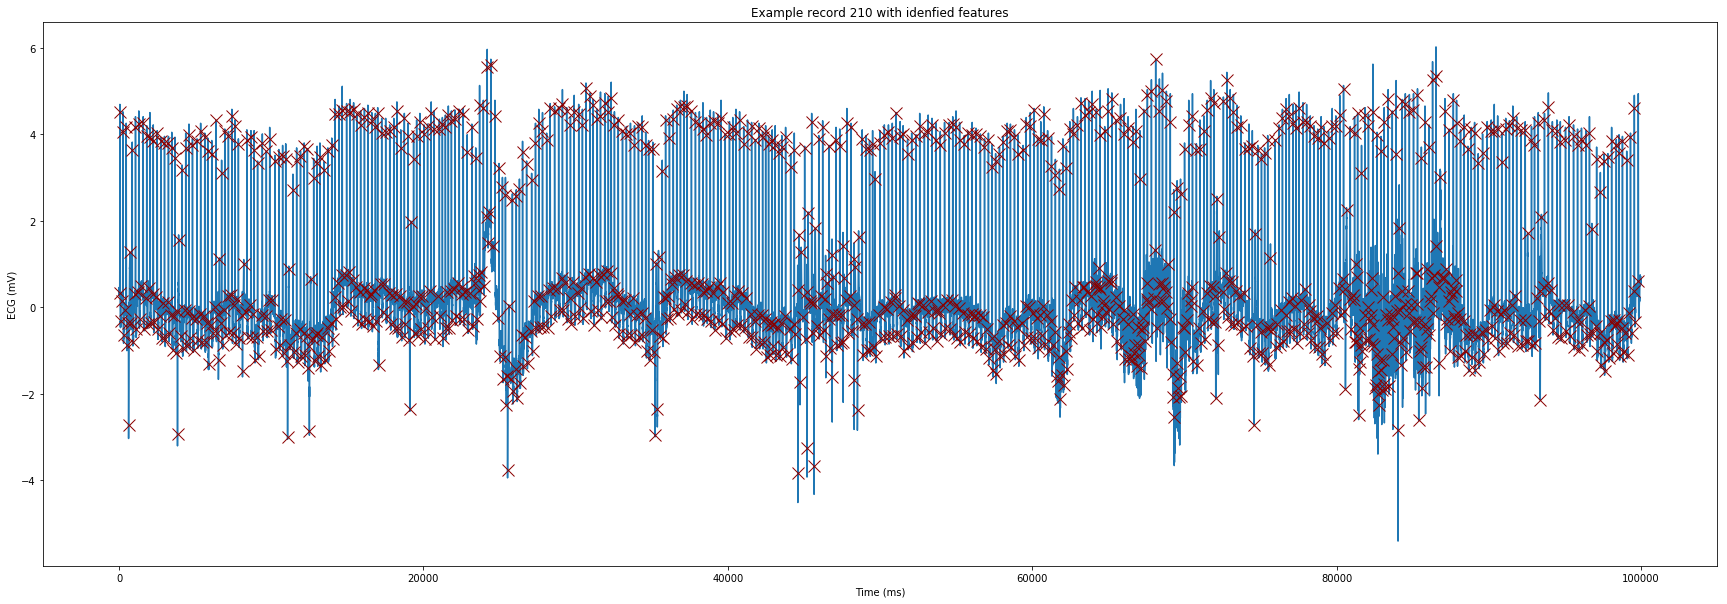

In [91]:
lowcut=.5      #low frequency cutoff for bandpass filter
highcut=3   #high frequency cutoff for bandpass filter
window=10     #window size for moving window integration3

zero_crossings = []

nyquist_freq = 0.5 * record.fs #calculating the nyquist frequency using the sampling frequency
low = lowcut / nyquist_freq #lowpass filtering cutoff
high = highcut / nyquist_freq #highpass filtering cutoff
bf, af = butter(1, [low, high], btype="band")
for i in range(len(pchannel)):
    xf = lfilter(bf, af, pchannel[i]) #bandpass filtering
    yf = np.ediff1d(xf) #deriving the data
    fin = np.convolve(yf, np.ones(window)/window, mode='valid') #moving window average smoothing
    zero_crossings.append(np.where(np.diff(np.sign(fin)))[0]) #find the zero crossings in the differential ie minima and maxima

    mfreq = recordall[i].fs * 0.05 #the minimum datapoints between peaks that's physiologically possible
    mamp = 0.5 #arbitrary amplitude difference to prevent repeated values
    t=0
    l=len(zero_crossings[i])
    while t < l-1:
        if abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) > abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t], zero_crossings[i][t+1:]))
            l = len(zero_crossings[i])
        elif abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) < abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t+1], zero_crossings[i][t+2:]))
            l = len(zero_crossings[i])
        else:
            t += 1
            l = len(zero_crossings[i])

        #If two peak values are too close both in time and amplitude, this keeps one value

plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb])
plt.plot(zero_crossings[datanumb][:-2]-3, pchannel[datanumb][zero_crossings[datanumb][:-2]-3], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
anno = [annall[datanumb].sample, annall[datanumb].symbol]
print(anno[0])
plt.title('Example record '+file_nums[datanumb]+' with idenfied features')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')





Segmentation of data into time frames based on proximity to arrythmic beat. There are two different ways of separating the data. A) The entire dataset is separated into beats along with their annotations and RR distance. In this case, the raw data of each beat and/or some features/statistics could be put into a one vs all classifier. B) The dataset could be separated into arrythmic beats (desired output) and time frames of beats before the arrythmia (input). These inputs and lagged inputs could be reduced in dimentionality using PCA and then be used for training using one vs all, or they could be transformed using techniques such as Fourier transform and used for other prediction algorithms (regression?). Single beats are also possible in this case.

Part A beat type: N
Part B label of beat is N


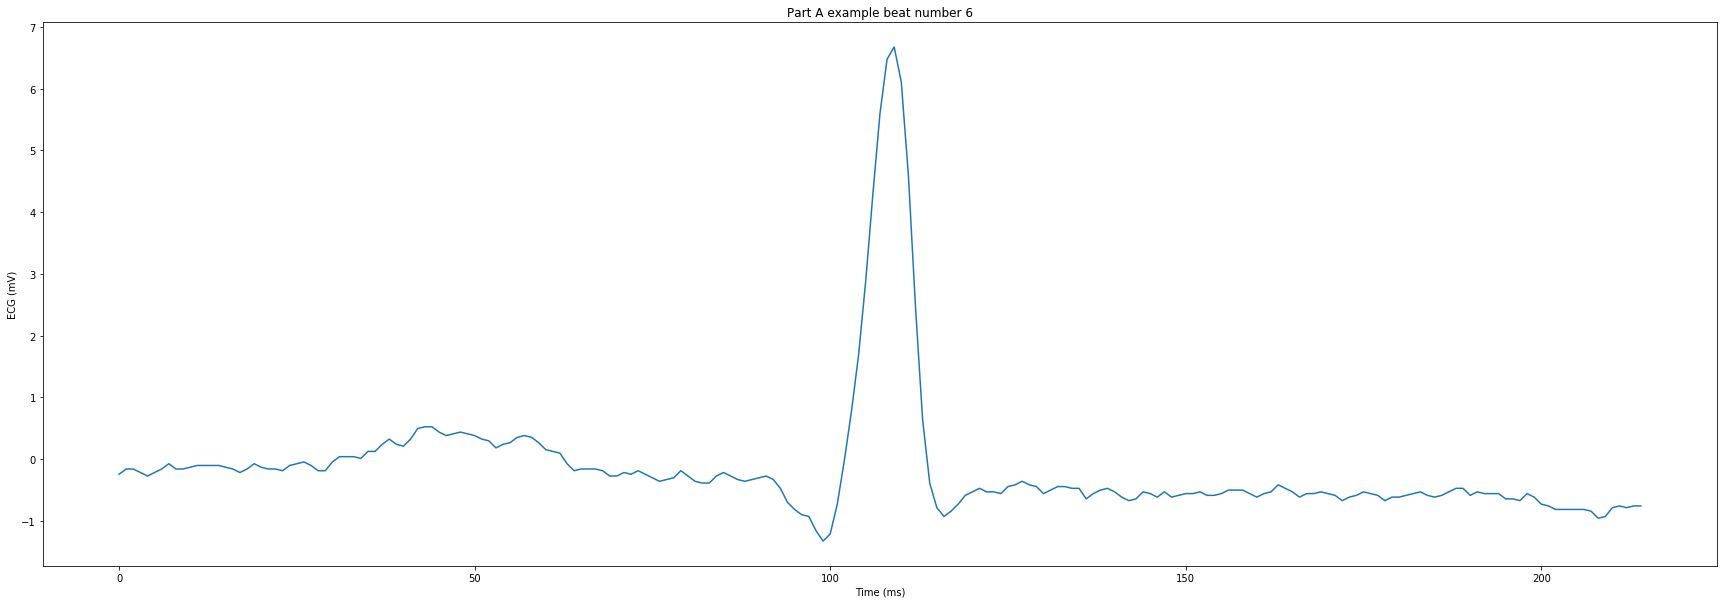

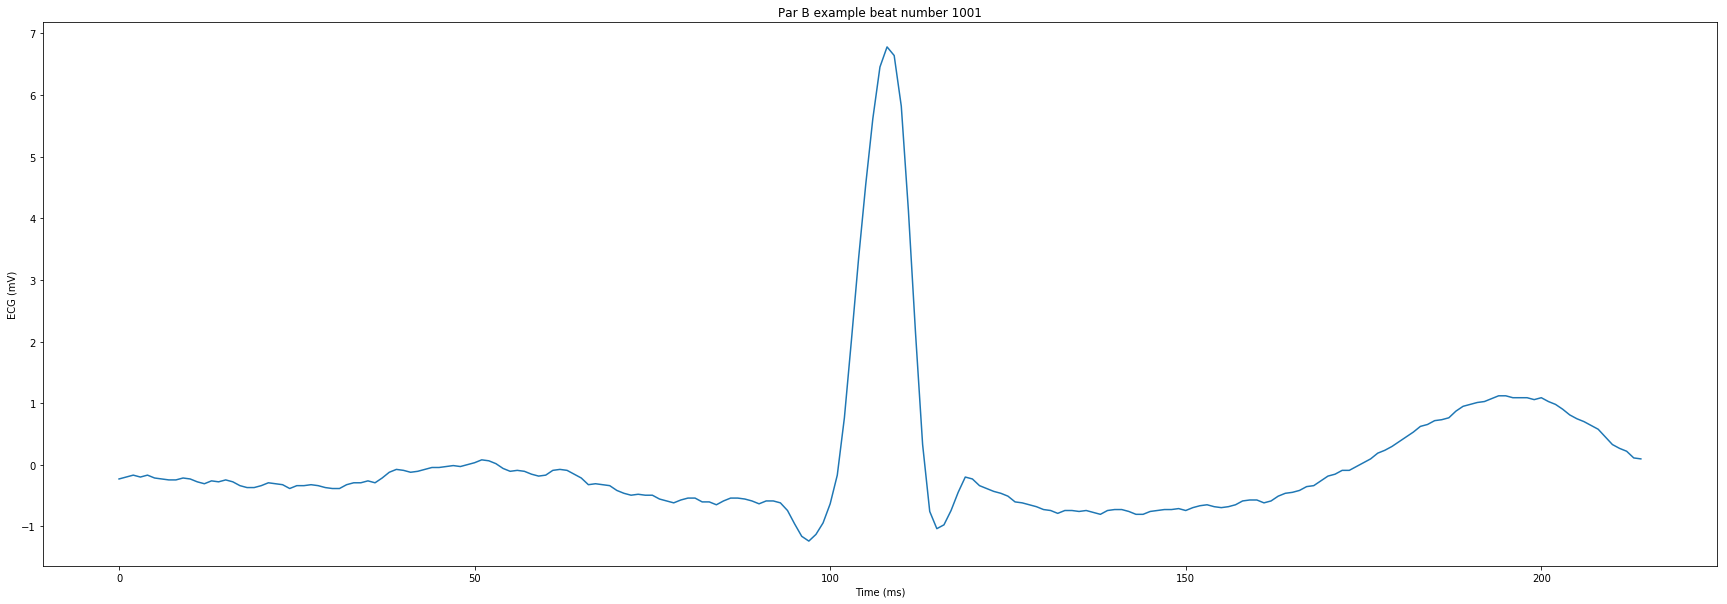

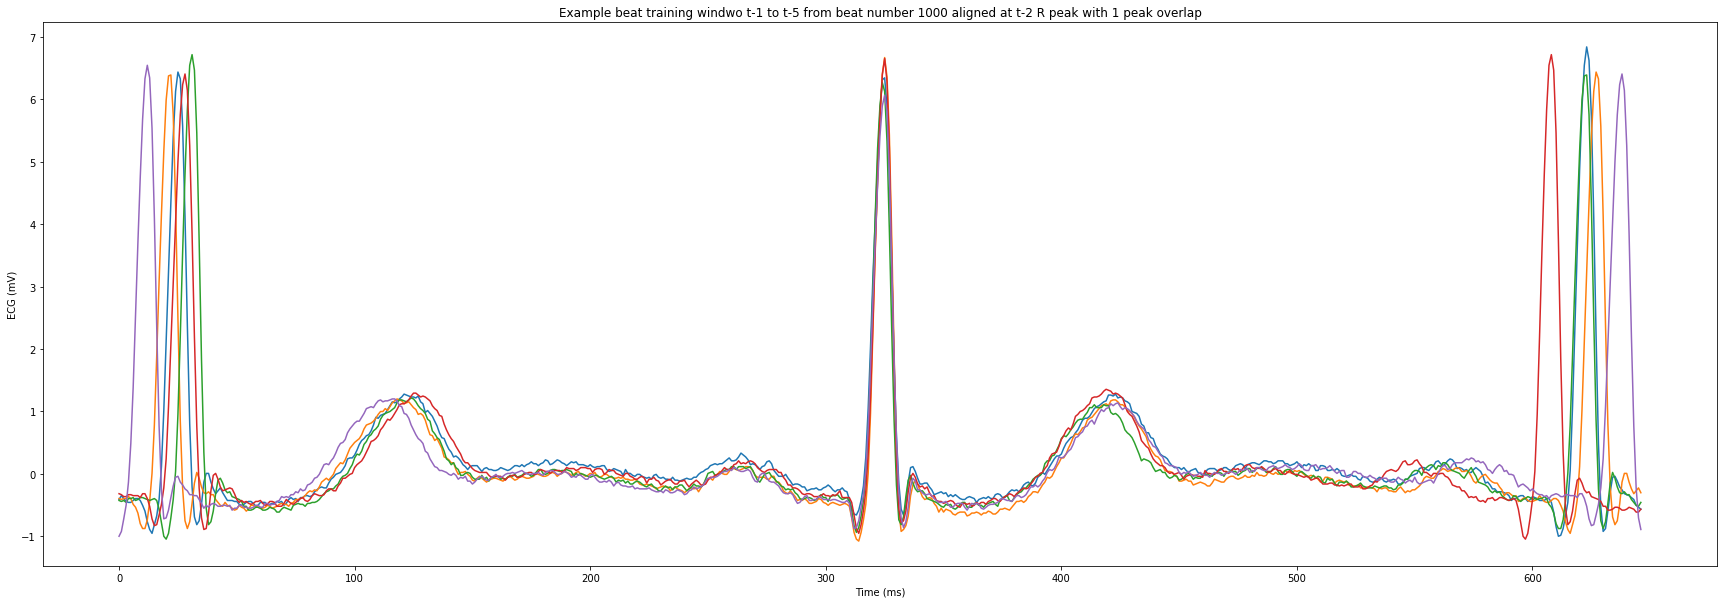

In [92]:
wr = 3 #average amount of heart beats/R peaks for a segment
ws = 2 #peak alignment for the windows counting from the direction of the arrythmic beat
over = 1 #peak overlap allowed between windows

dat = 1000 #visualize which arrythmic window for part B
dat2 = 5 #visualize which beat for part A

nrry=[] #setting up list of predicted/expected beats for learning
arry=[] #setting up list of beat annotations for arry

allbeat=[] #a concatination of all individual beats
allbeatan=[] #annotations for allbeat

normalt1=[] #setting up list of input beat windows for arry t-1
normalt2=[] #t-2
normalt3=[] #t-3
normalt4=[] #t-4
normalt5=[] #t-5

annsym=[] #setting up annotation lists without non-beat annotations
annsam=[] #setting up annotation location list without non-beat annotations

Nb=[] #normal beat
Lb=[] #Left bundle branch block beat
Rb=[] #Right bundle branch block beat
Bb=[] #Bundle branch block beat (unspecified)
Ab=[] #Atrial premature beat
ab=[] #Aberrated atrial premature beat
Jb=[] #Nodal (junctional) premature beat
Sb=[] #Supraventricular premature or ectopic beat (atrial or nodal)
Vb=[] #Premature ventricular contraction
rb=[] #R-on-T premature ventricular contraction
Fb=[] #Fusion of ventricular and normal beat
eb=[] #Atrial escape beat
jb=[] #Nodal (junctional) escape beat
nb=[] #Supraventricular escape beat (atrial or nodal)
Eb=[] #Ventricular escape beat
Pb=[] #Paced beat actual symbol /
fb=[] #Fusion of paced and normal beat
Qb=[] #Unclassifiable beat

hry=[]
tlen=[]
for i in range(len(hrs)):
    hrs2 = hrs[i][~np.isnan(hrs[i])]
    hry.append(sum(hrs2[~np.isinf(hrs2)]) / len(hrs2[~np.isinf(hrs2)])) #average heart rate
    tlen.append(int(recordall[i].fs / (hry[i] / 60)))
#Set the total length of the segmented data to specified wr times the average heart rate

ttlen=tlen
tlen=sum(ttlen)/len(ttlen)

abl=['L','R','B','A','a','J','S','V','r','F','e','j','n','E','P','f','Q'] #list of abnormal beats
bbl=['[','!',']','x','(',')','p','t','u','`','%','^','|','~','+','s','T','*','D','=','"','@'] #list of non-beat annotations

#peak_inds are the peak found through calculation while annall[datanumb] is the annotated peaks

for t in range(len(annall)):
    annsymb=[]
    annsamb=[]
    for i in range(len(annall[t].symbol)): #This is to eliminate non-R-peak annotations in the data
        if annall[t].symbol[i] not in bbl:
            annsymb += annall[t].symbol[i]
            annsamb = np.append(annsamb, annall[t].sample[i])
    annsym.append(annsymb)
    annsam.append(annsamb)

for i in range(len(annsym)):
    Nb.append([i for i, x in enumerate(annsym[i]) if x == "N"]) #get indices of all the different beats for later use
    Lb.append([i for i, x in enumerate(annsym[i]) if x == "L"])
    Rb.append([i for i, x in enumerate(annsym[i]) if x == "R"])
    Bb.append([i for i, x in enumerate(annsym[i]) if x == "B"])
    Ab.append([i for i, x in enumerate(annsym[i]) if x == "A"])
    ab.append([i for i, x in enumerate(annsym[i]) if x == "a"])
    Jb.append([i for i, x in enumerate(annsym[i]) if x == "J"])
    Sb.append([i for i, x in enumerate(annsym[i]) if x == "S"])
    Vb.append([i for i, x in enumerate(annsym[i]) if x == "V"])
    rb.append([i for i, x in enumerate(annsym[i]) if x == "r"])
    Fb.append([i for i, x in enumerate(annsym[i]) if x == "F"])
    eb.append([i for i, x in enumerate(annsym[i]) if x == "e"])
    jb.append([i for i, x in enumerate(annsym[i]) if x == "j"])
    nb.append([i for i, x in enumerate(annsym[i]) if x == "n"])
    Eb.append([i for i, x in enumerate(annsym[i]) if x == "E"])
    Pb.append([i for i, x in enumerate(annsym[i]) if x == "/"])
    fb.append([i for i, x in enumerate(annsym[i]) if x == "f"])
    Qb.append([i for i, x in enumerate(annsym[i]) if x == "Q"])


#This first part A is to separate each beat individualy using the average heart rate. Included with it will be beat to beat RR distance
#and other features from the last cell

for t in range(len(pchannel)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]): #make sure the beats we get are within the window ranges
            allbeat.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            #append all beats
            allbeatan.append(annsym[t][i])
            #append all annotations aligning with the beats
    
plt.figure(figsize=(30,10))
plt.plot(allbeat[dat2])
plt.title('Part A example beat number '+str(dat2+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part A beat type: '+allbeatan[dat2])

#This second part B is to see if the beats before the arrythmic beat could be used to predict the arrythmic beat. This will use raw lagged
#data as the input and the arrythmic beats themselves as the desired output. For data consistency, the data length will be
#normalized to the length of the number of heartbeats specified in wr according to the average heart rate. All of the data
#will also be aligned to specific peaks for data point alignment to optimize training.


for t in range(len(annsym)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]): #skips over beats that can't accomdate all time frames
            nrry.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            arry.append(annsym[t][i])
            #append all delayed windows
            normalt1.append(pchannel[t][int(annsam[t][i-ws]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws]+ws*tlen-tlen/2)]) 
            normalt2.append(pchannel[t][int(annsam[t][i-ws-wr+over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-wr+over]+ws*tlen-tlen/2)])
            normalt3.append(pchannel[t][int(annsam[t][i-ws-2*wr+2*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-2*wr+2*over]+ws*tlen-tlen/2)])
            normalt4.append(pchannel[t][int(annsam[t][i-ws-3*wr+3*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-3*wr+3*over]+ws*tlen-tlen/2)])
            normalt5.append(pchannel[t][int(annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-4*wr+4*over]+ws*tlen-tlen/2)])
            #append all different data windows right before the annotated beats       

plt.figure(figsize=(30,10))
plt.plot(nrry[dat])
plt.title('Par B example beat number '+str(dat+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part B label of beat is '+arry[dat])

plt.figure(figsize=(30,10))
plt.plot(normalt1[dat])
plt.plot(normalt2[dat])
plt.plot(normalt3[dat])
plt.plot(normalt4[dat])
plt.plot(normalt5[dat])
plt.title('Example beat training windwo t-1 to t-5 from beat number '+str(dat)+' aligned at t-'+str(ws)+' R peak with '+str(over)+' peak overlap')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')


    

Attempts at raw data decomposition for part B: transforming the different time windows from segmentation will allow us to bypass timing restrictions. First to try is Fourier Transform.

Text(0.5,1,'Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #210')

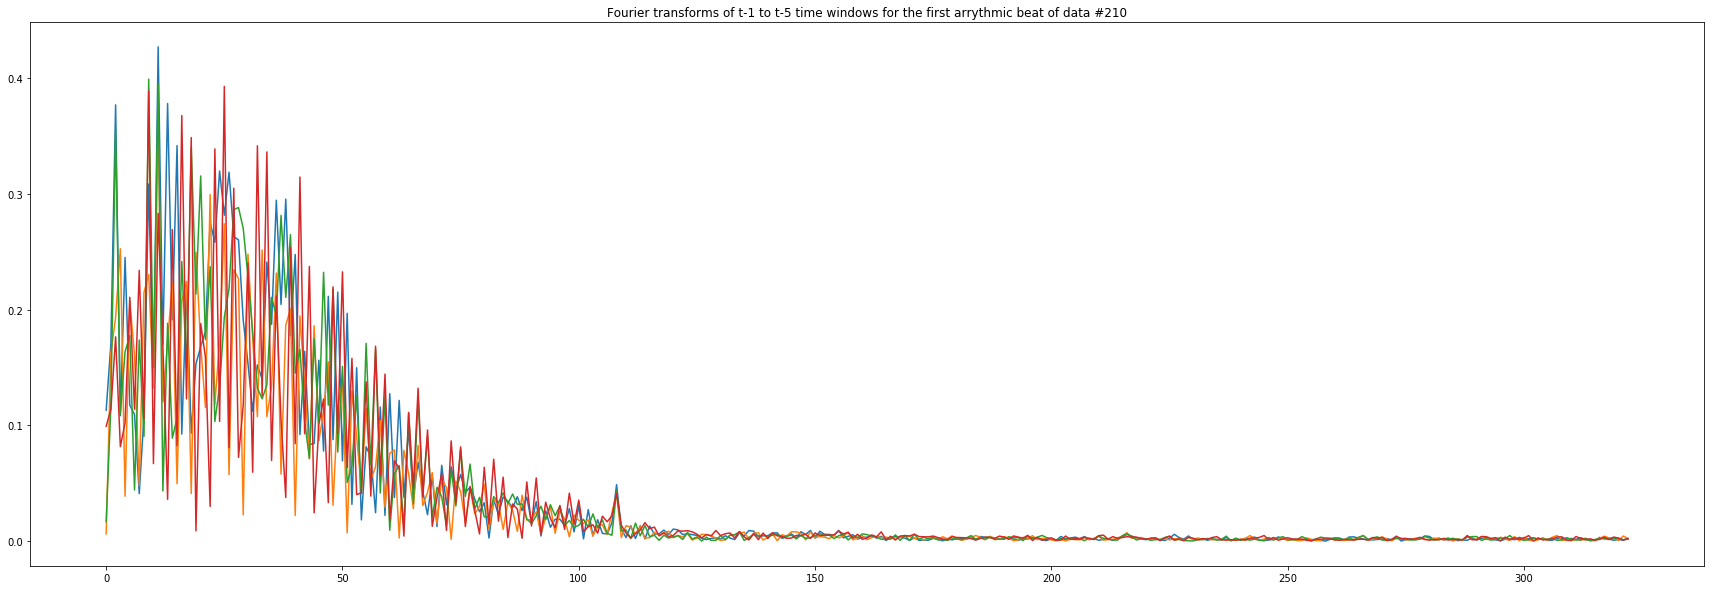

In [93]:
#Fourier transform of normalt raw data windows
fnormalt1=[]
fnormalt2=[]
fnormalt3=[]
fnormalt4=[]
fnormalt5=[]

N = len(normalt1[0]) #number of sample points

for i in range(len(normalt5)):
    try:
        fnormalt1.append(fft(normalt1[i])) #Fourier transform of all data
        fnormalt2.append(fft(normalt2[i]))
        fnormalt3.append(fft(normalt3[i]))
        fnormalt4.append(fft(normalt4[i]))
        fnormalt5.append(fft(normalt5[i]))
    except ValueError:
        pass
plt.figure(figsize=(30,10))
plt.plot(2.0/N * np.abs(fnormalt1[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt2[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt3[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt4[0][:N//2]))
#plt.plot(2.0/N * np.abs(fnormalt5[0][:N//2]))
plt.title('Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #'+file_nums[datanumb])

#widths = np.arange(1, 31)
#cwtmatr = signal.cwt(normalt1[dat], signal.ricker, widths)
#plt.figure(figsize=(30,10))
#plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

Using the Fourier Transforms above as well as the raw data from part B, this part reduces the complexity of the data using PCA and initiates the linear prediction algorithm

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


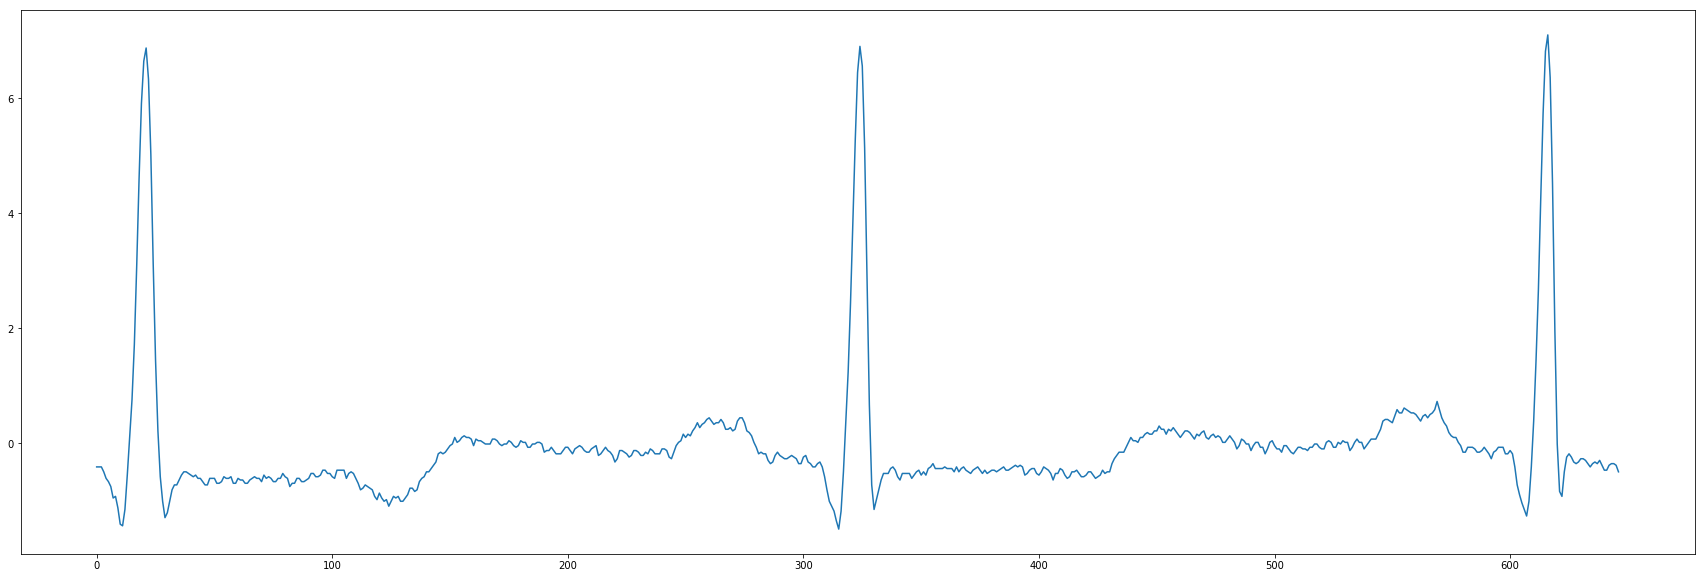

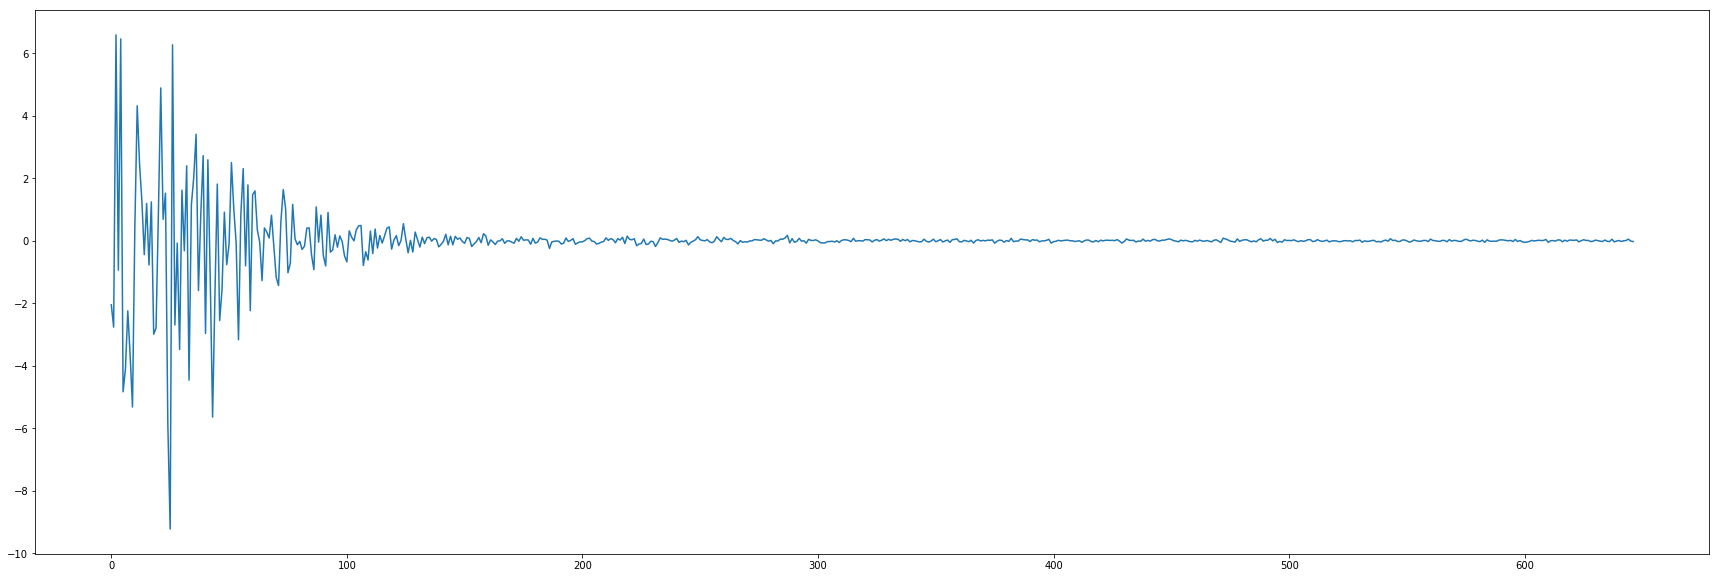

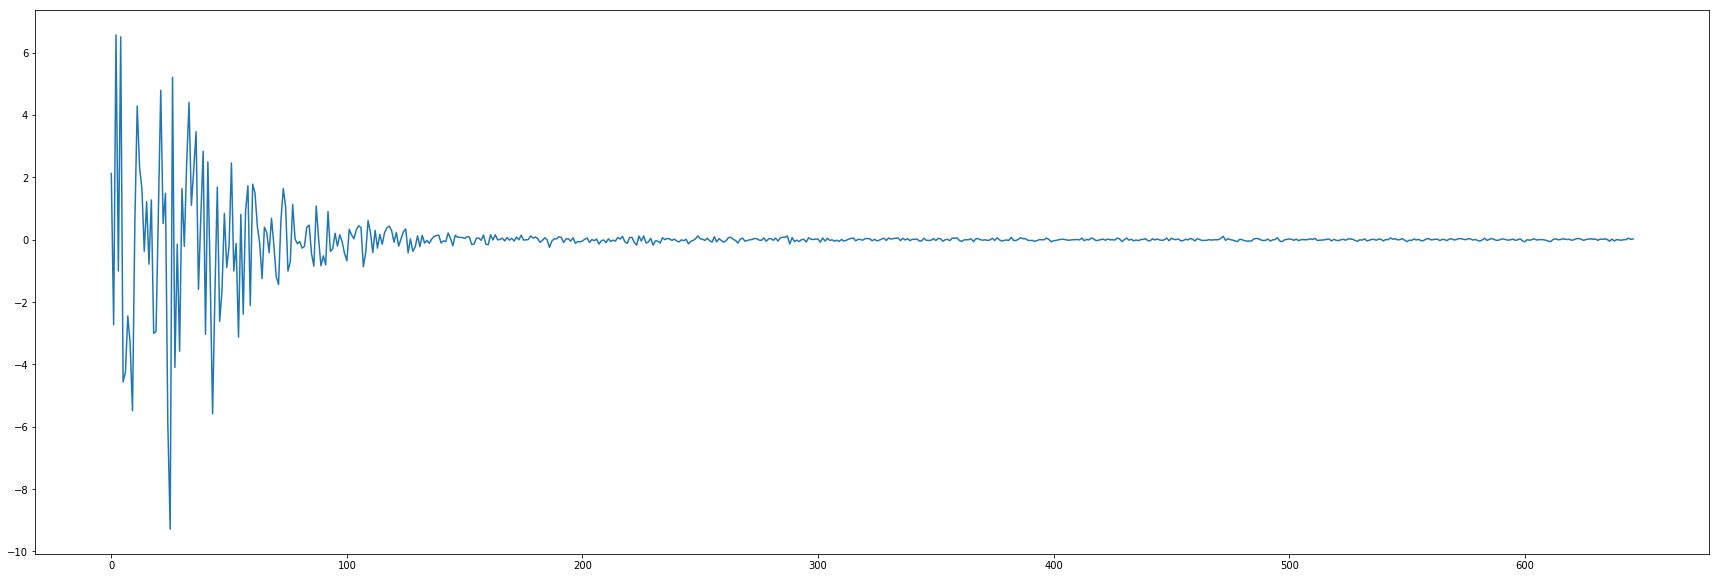

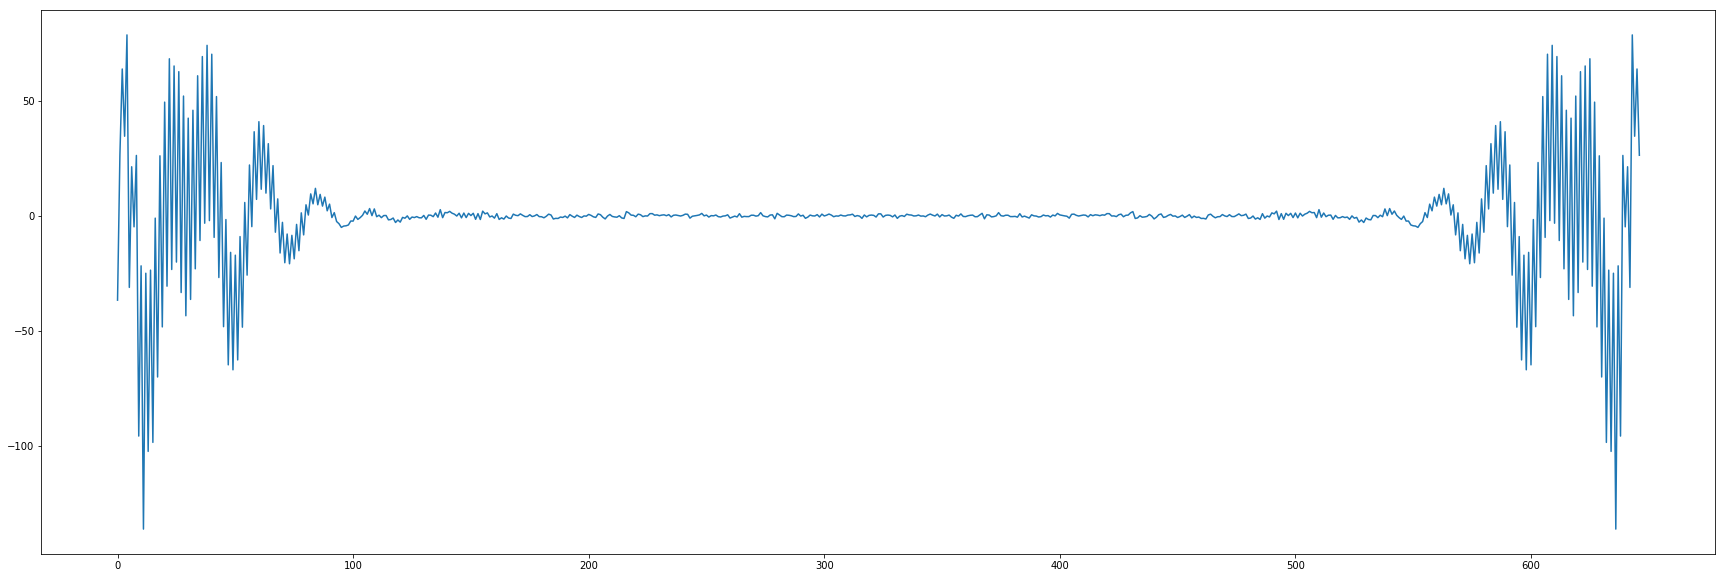

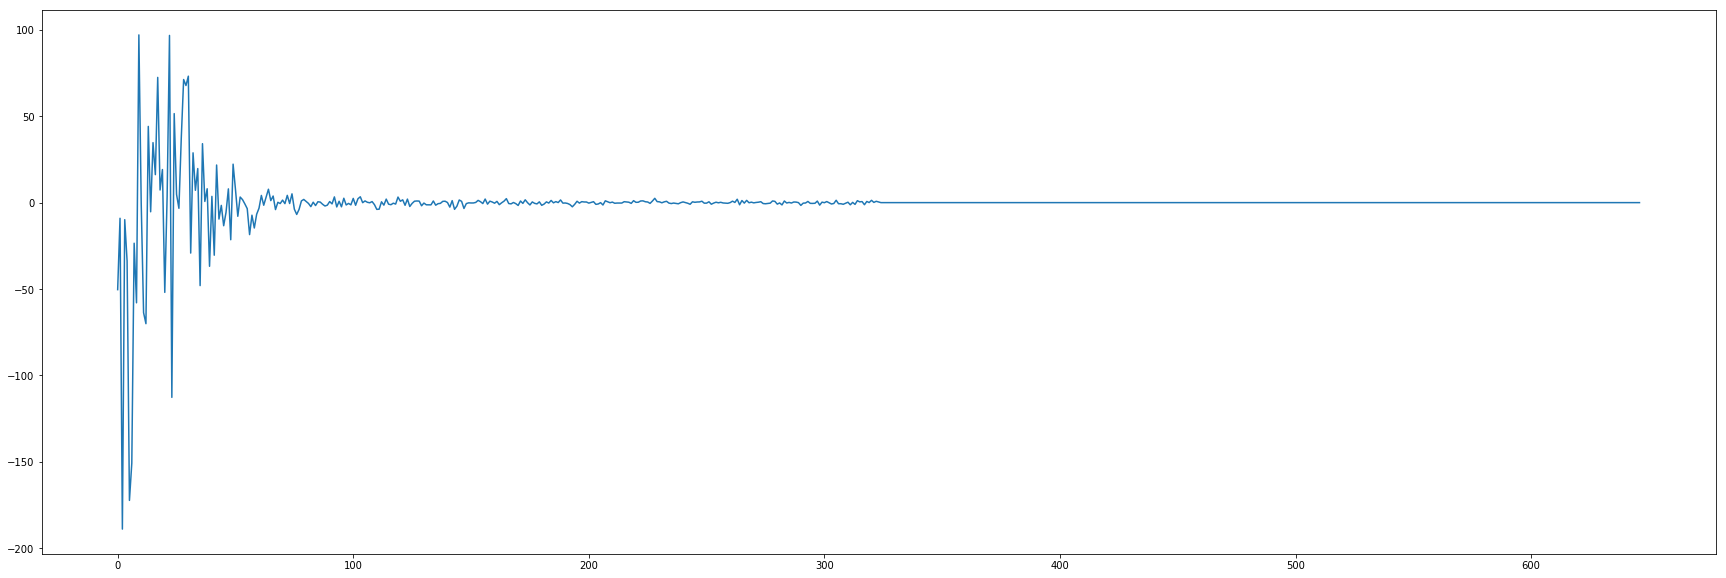

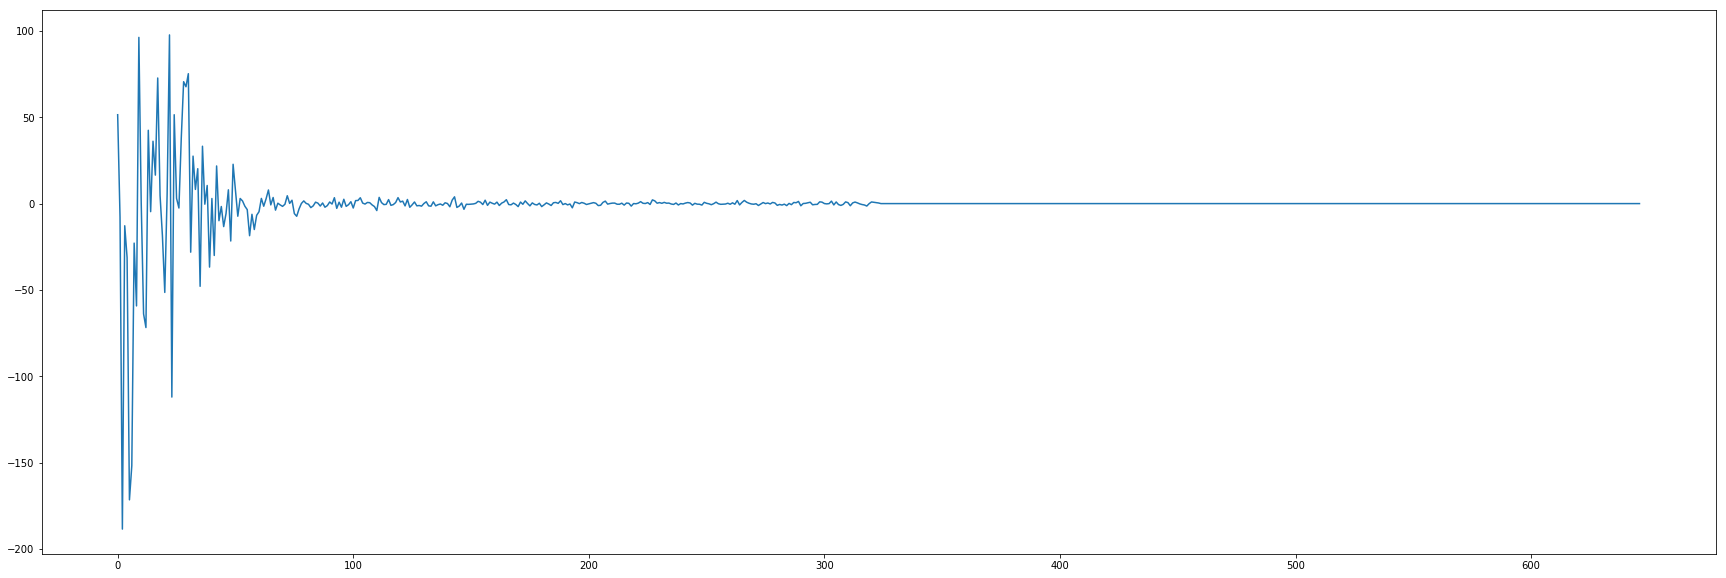

In [94]:
pca = PCA()

alln=np.squeeze(np.array([normalt1+ normalt2+ normalt3+ normalt4 +normalt5])) #set up an array to learn across all time windows at once
allf=np.squeeze(np.array([fnormalt1+ fnormalt2+ fnormalt3+ fnormalt4 + fnormalt5])) #all time windows in the frequency domain

i = np.identity(alln.shape[1])  # identity matrix
reducedn = pca.fit_transform(alln) #PCA on all time windows
reducednpc = pca.components_ #Get the principal components
coefn = pca.transform(i) #Get the weights
coefn = matmul(alln,coefn)

i = np.identity(np.array(normalt1).shape[1])
reducedn1 = pca.fit_transform(np.array(normalt1)) #PCA on the first time window only
reducedn1pc = pca.components_
coefn1 = pca.transform(i)
coefn1 = matmul(np.array(normalt1),coefn1)

i = np.identity(allf.shape[1])
reducedf = pca.fit_transform(allf) #PCA on all frequency transforms
reducedfpc = pca.components_
coeff = pca.transform(i)
coeff = matmul(allf,coeff)

i = np.identity(np.array(fnormalt1).shape[1])
reducedf1 = pca.fit_transform(np.array(fnormalt1)) #PCA on the frequency domain of the first window only
reducedf1pc = pca.components_
coeff1 = pca.transform(i)
coeff1 = matmul(np.array(fnormalt1),coeff1)

plt.figure(figsize=(30,10))
plt.plot(normalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedn[0])
plt.figure(figsize=(30,10))
plt.plot(reducedn1[0])
plt.figure(figsize=(30,10))
plt.plot(fnormalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedf[0])
plt.figure(figsize=(30,10))
plt.plot(reducedf1[0])



The R2 score for LR using raw first window input is: 0.48531195556608503


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The R2 score for LR using transformed first window input is: 8.131480489927871e+23
The R2 score for LR using PCA weights of first window input is: 0.48531195556608203
The R2 score for LR using PCA weights of transformed first window input is: 0.41339030015144007
The R2 score for LR using all raw inputs is: 0.40565194582871755
The R2 score for LR using all transformed input is: 1.5166004541326788e+25
The R2 score for LR using PCA weights of all raw input is: 0.40565194582870234
The R2 score for LR using PCA weights of all transformed input is: 0.3436105024068701


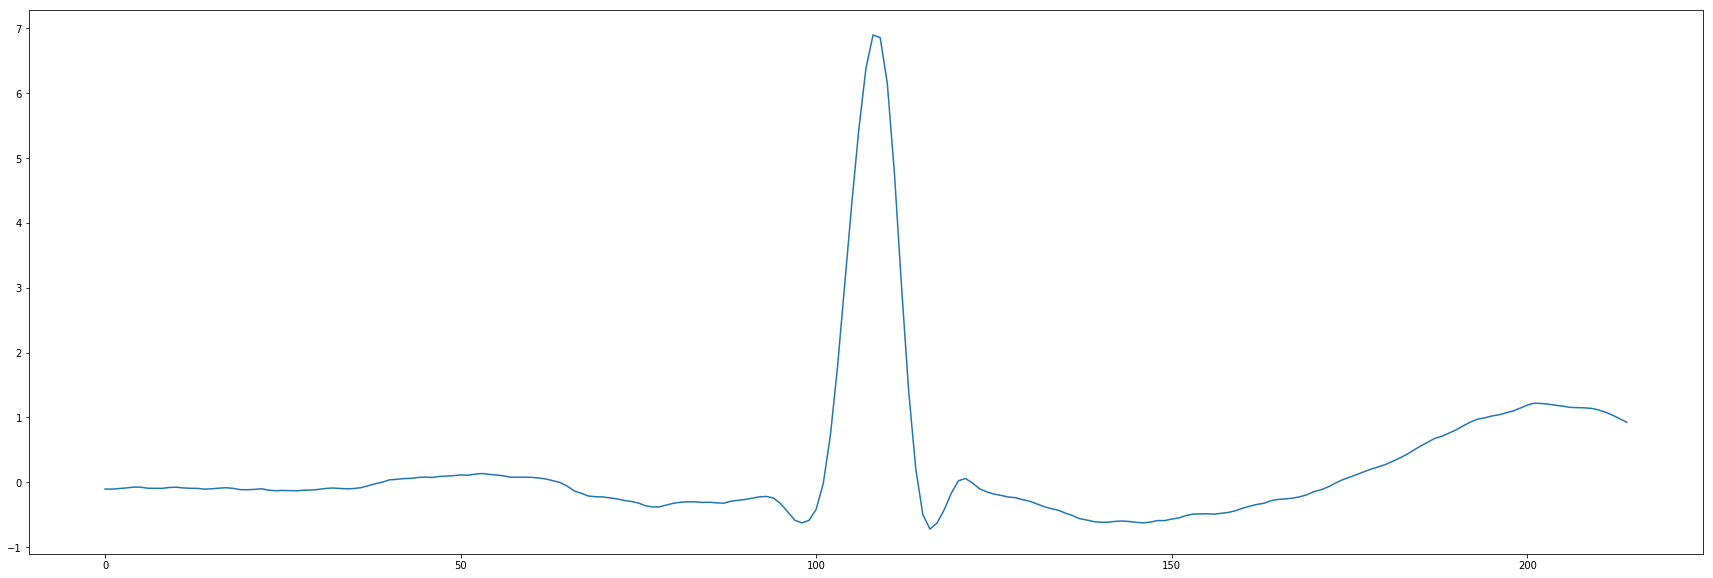

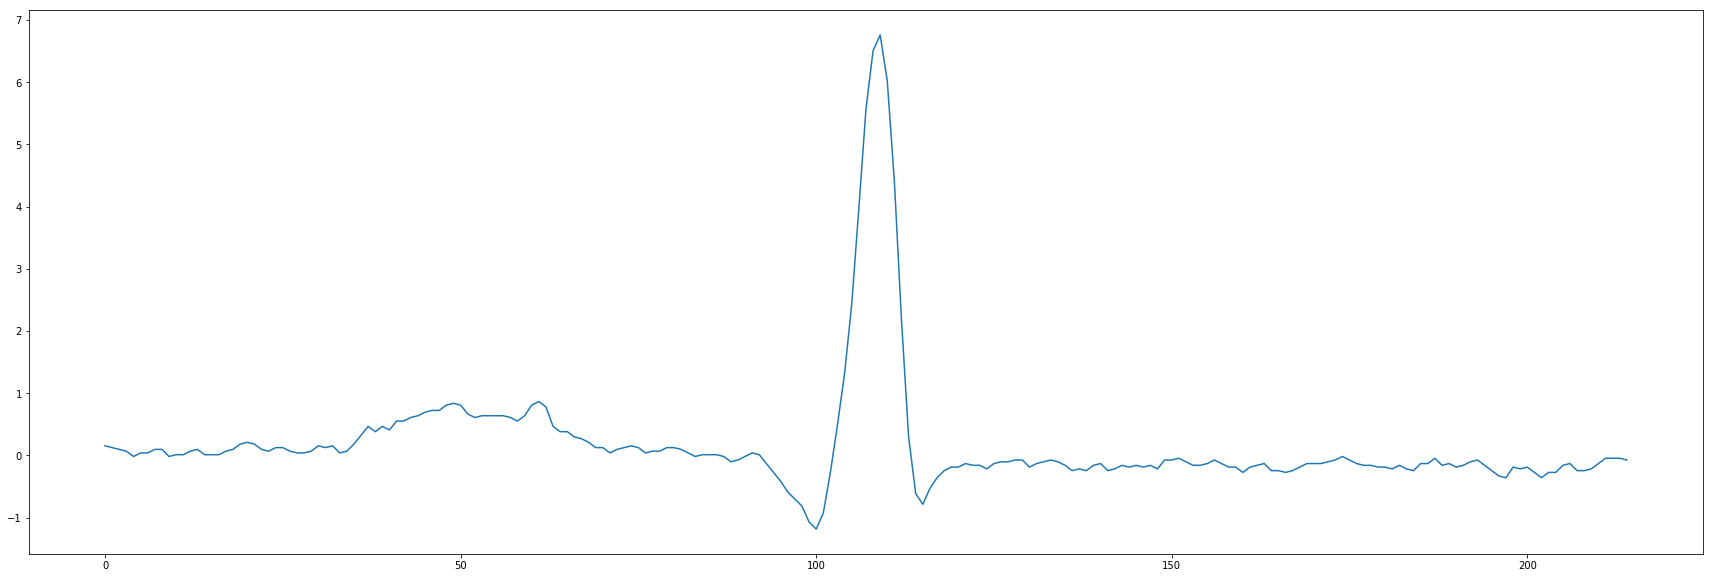

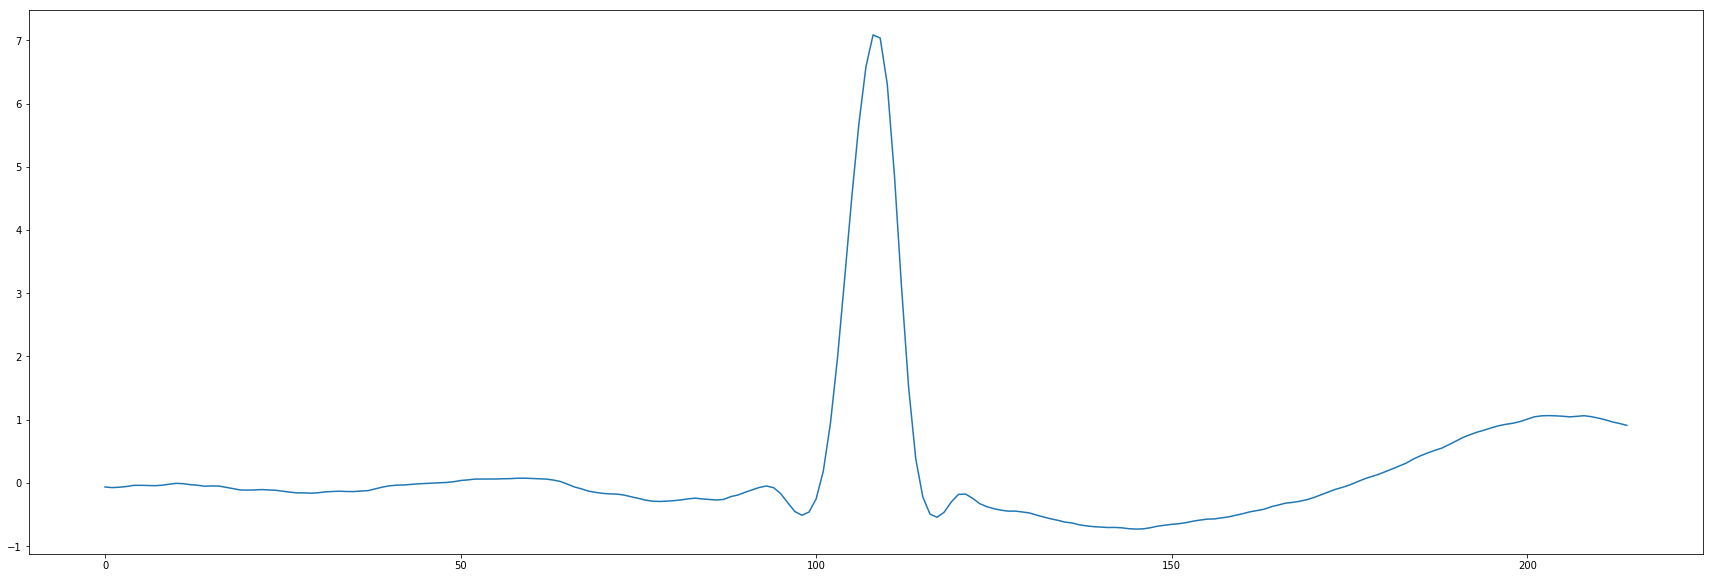

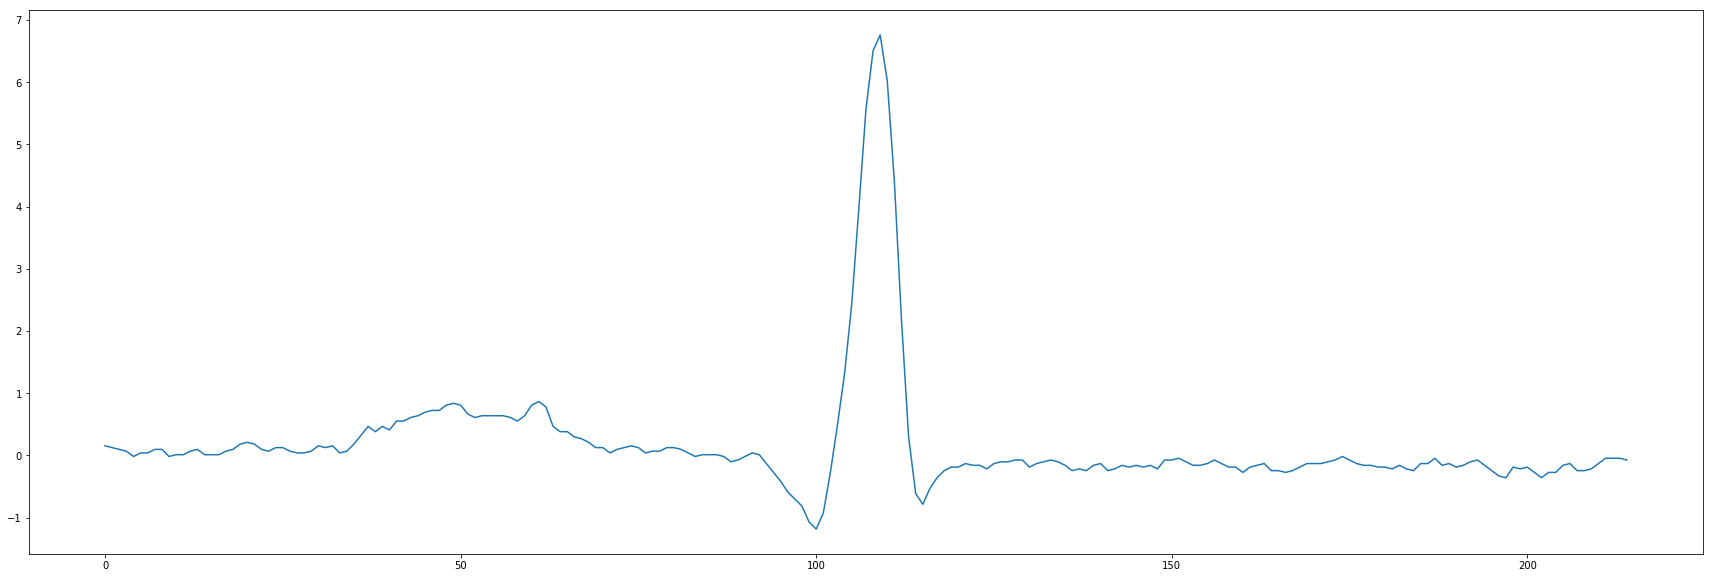

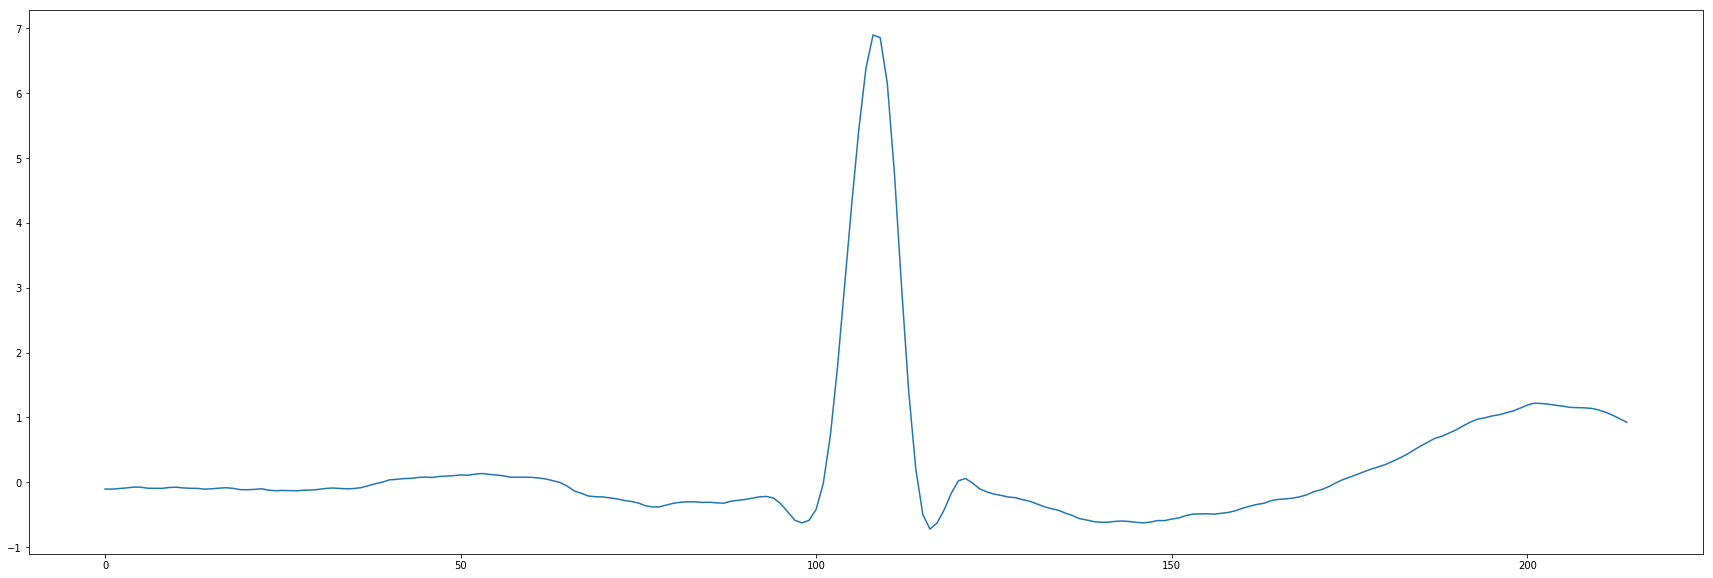

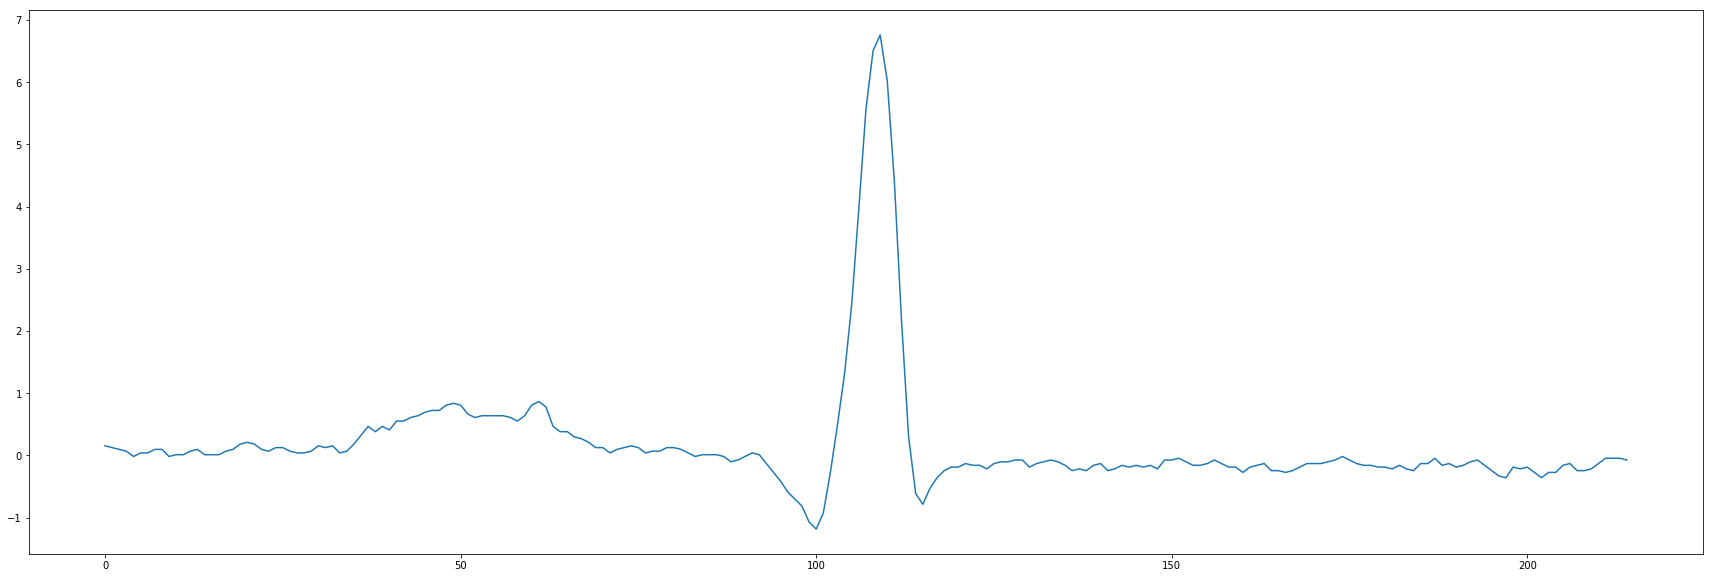

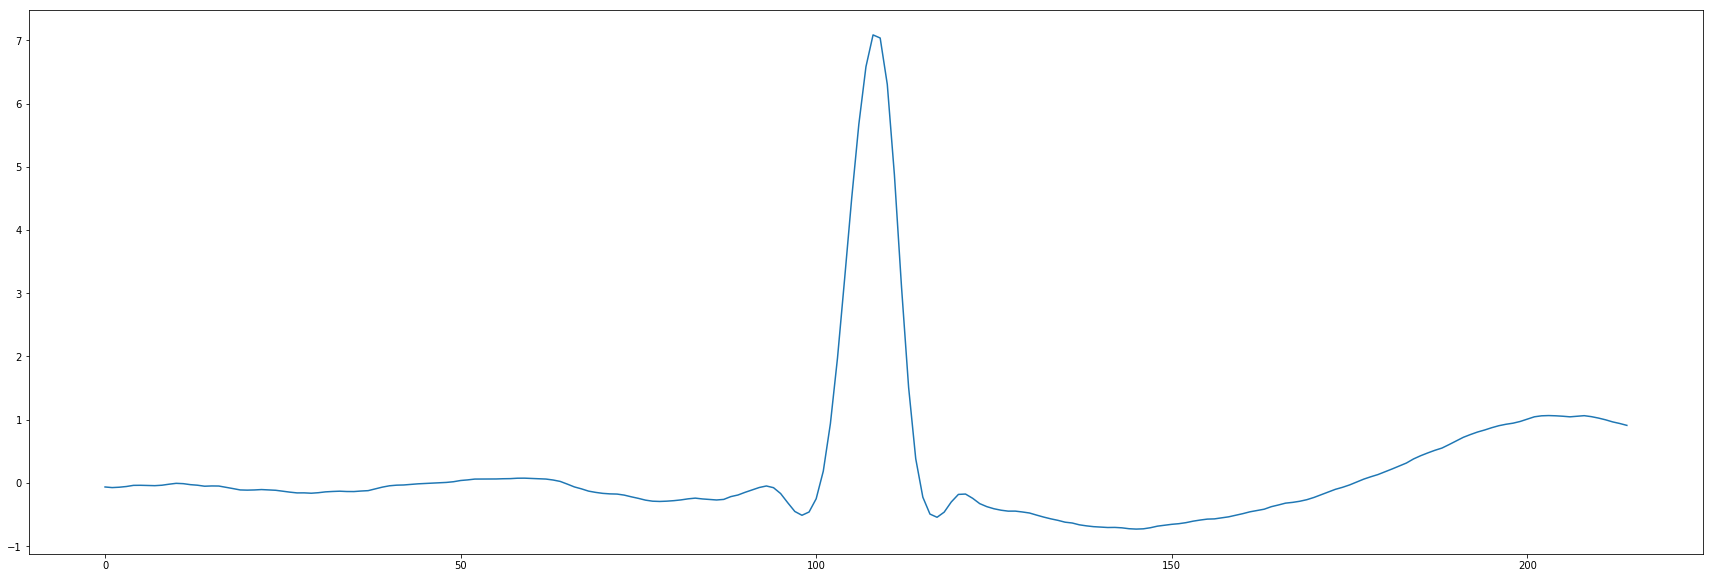

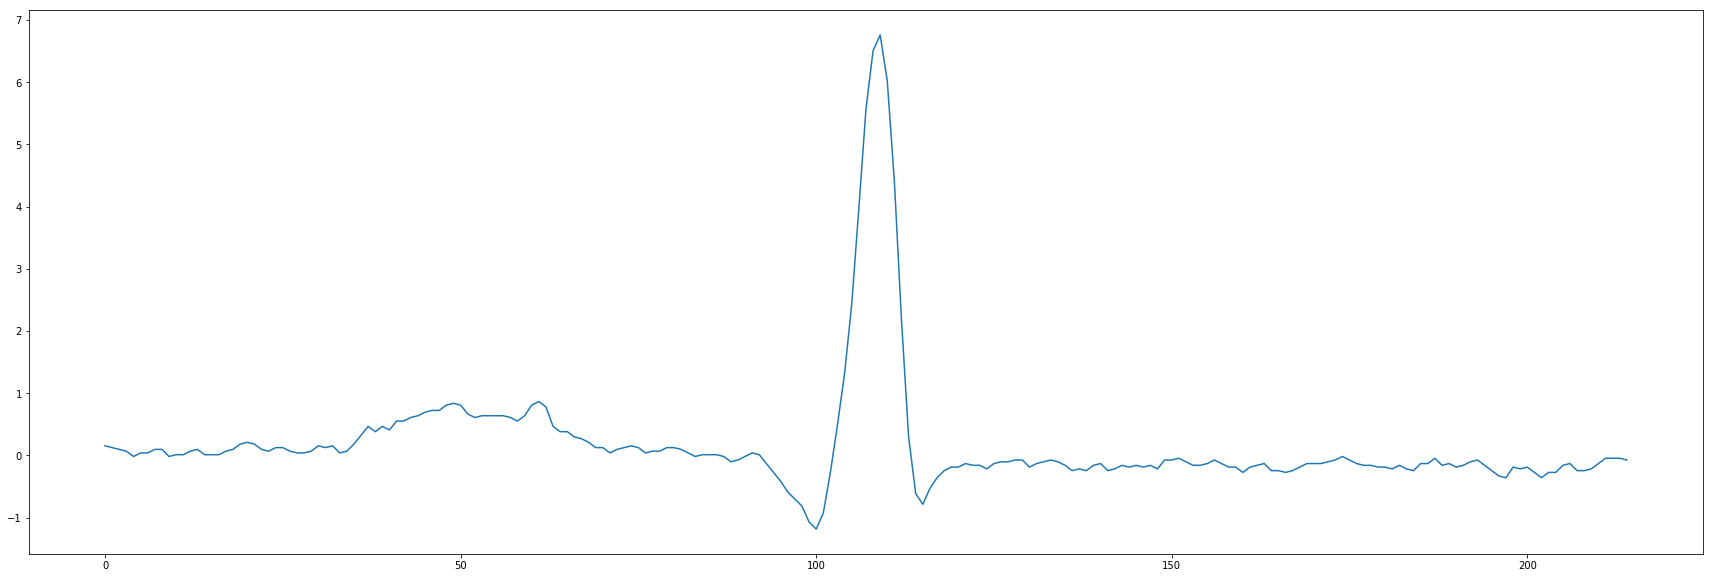

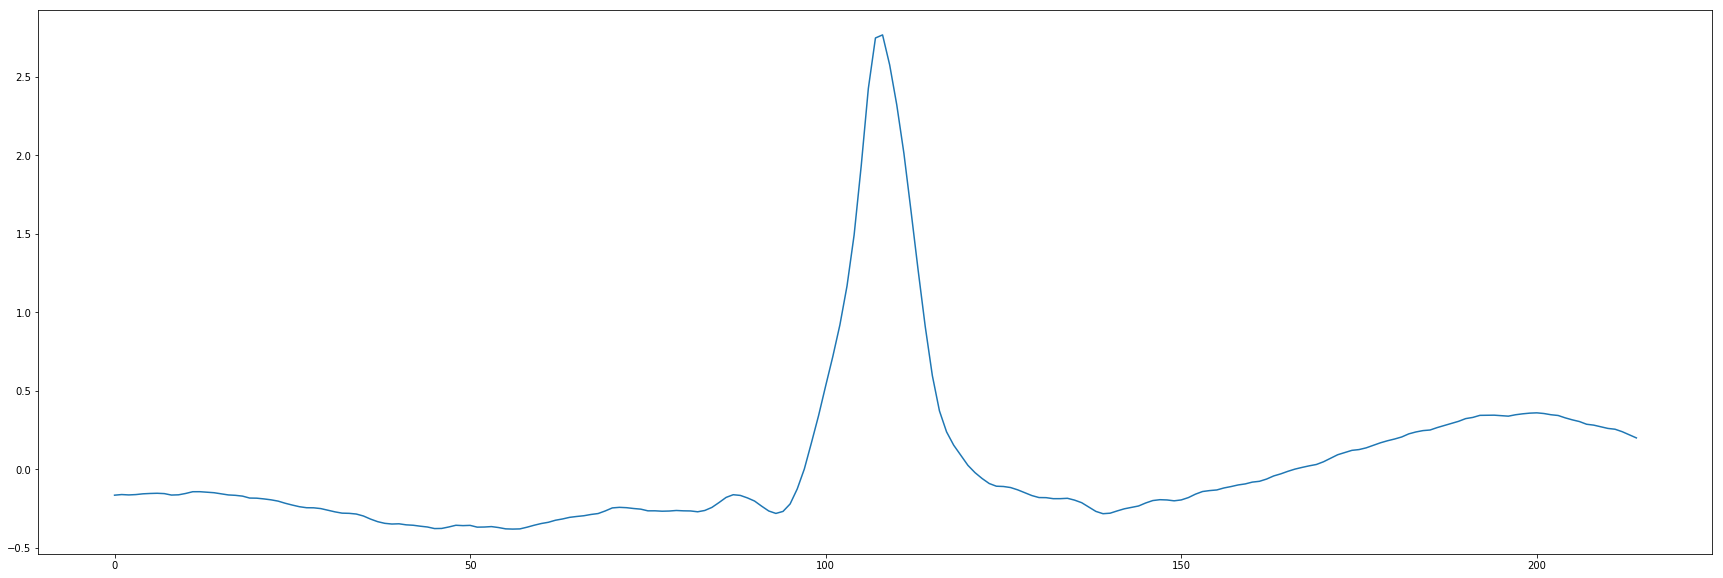

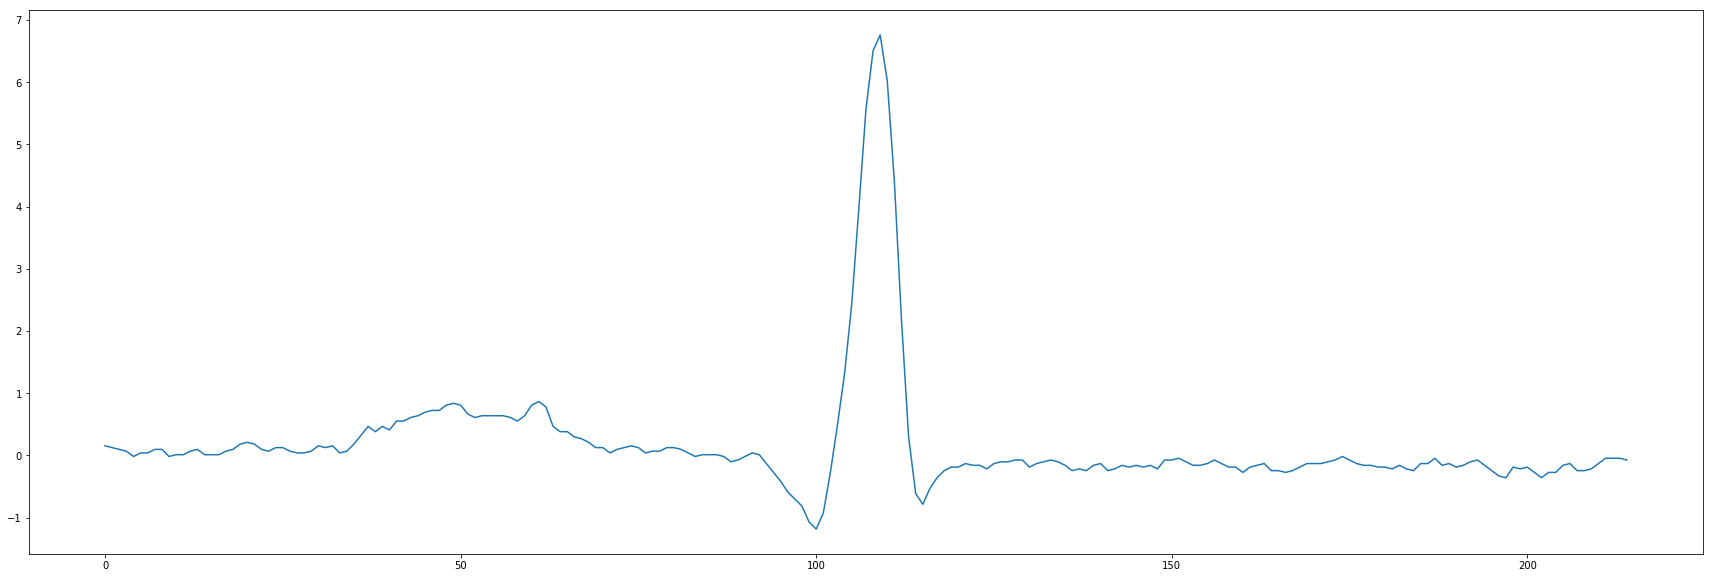

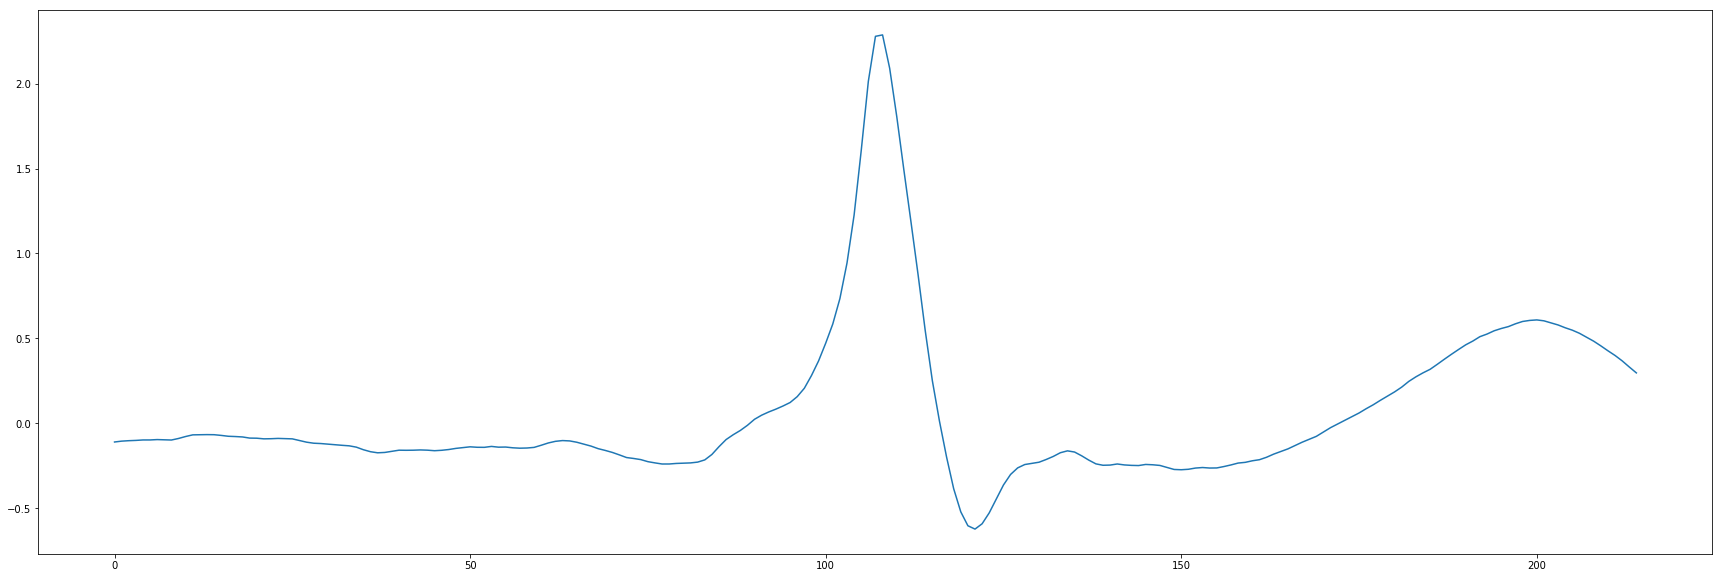

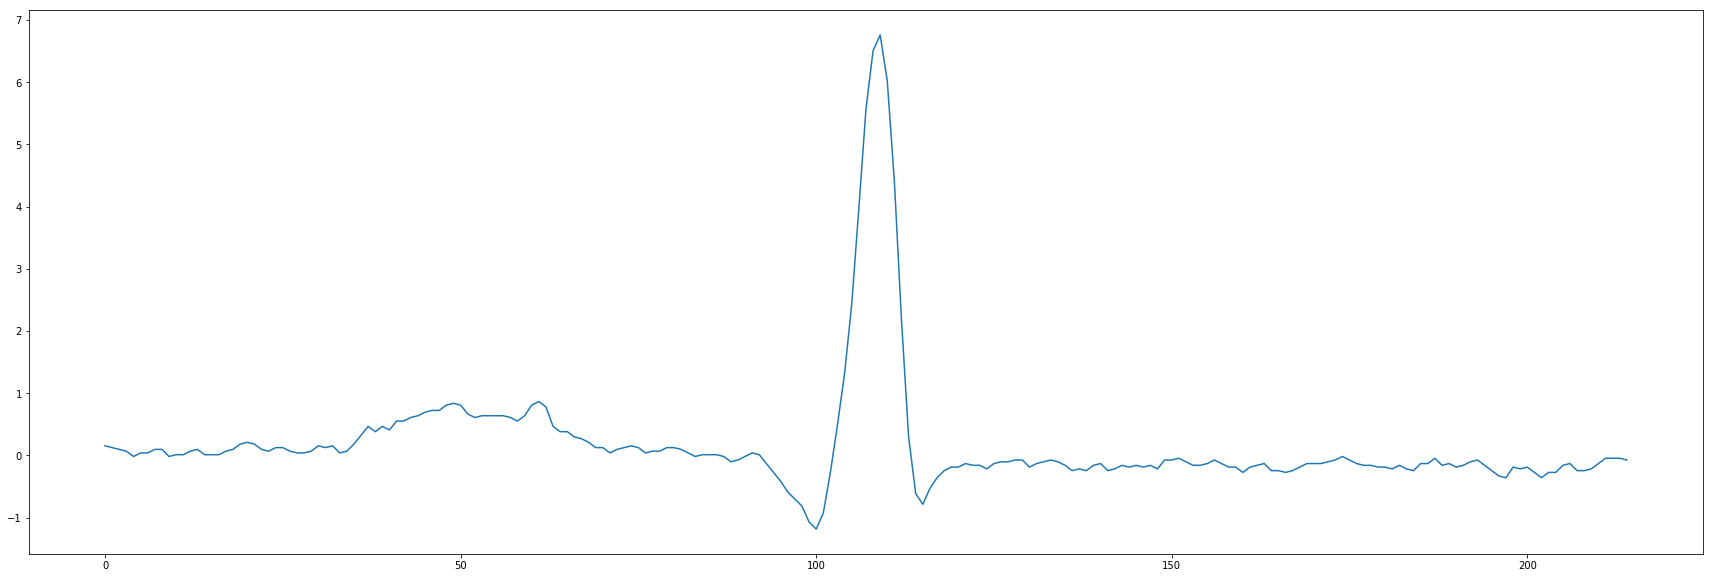

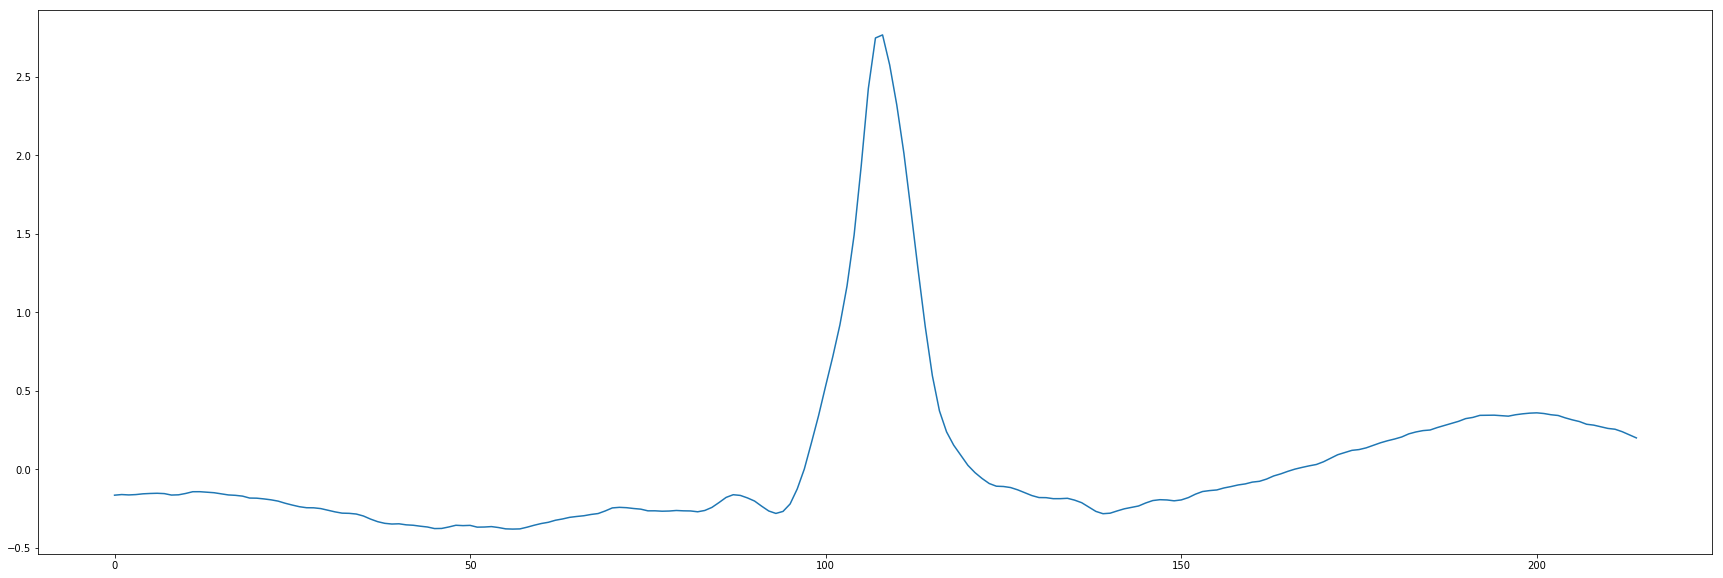

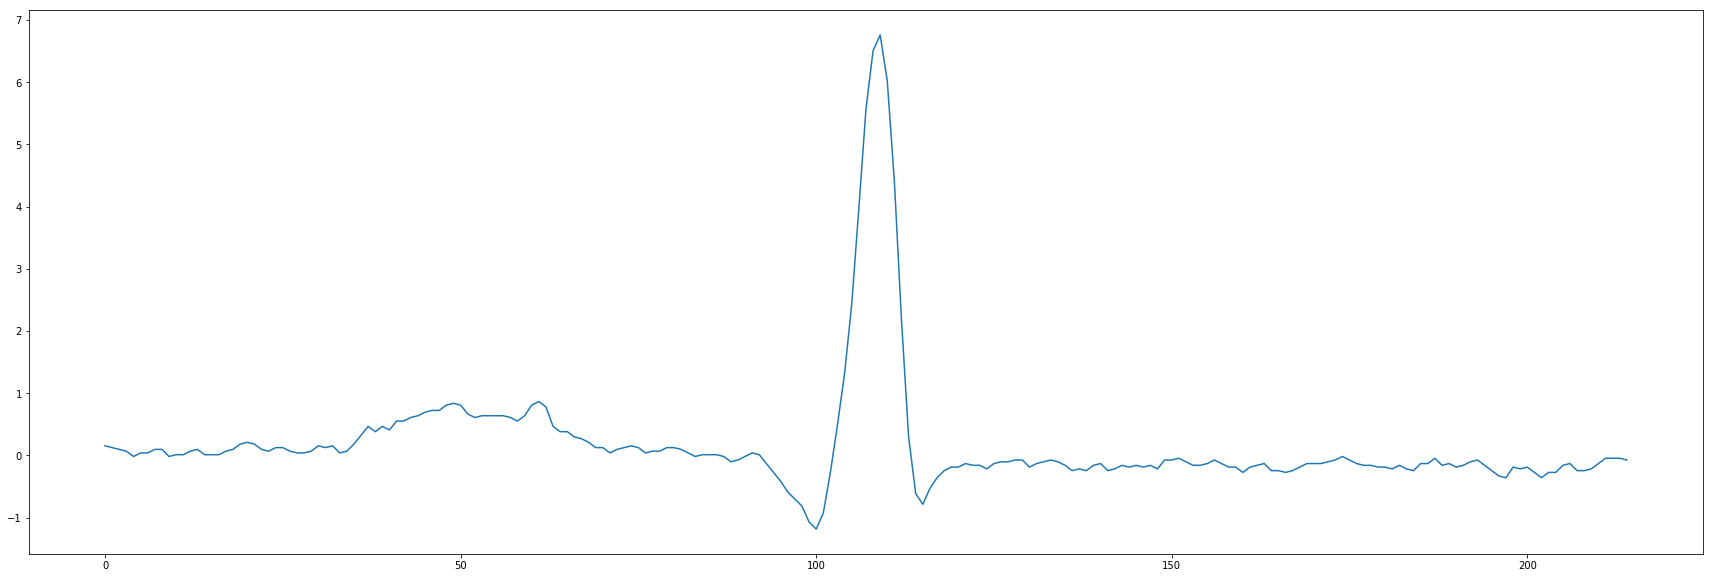

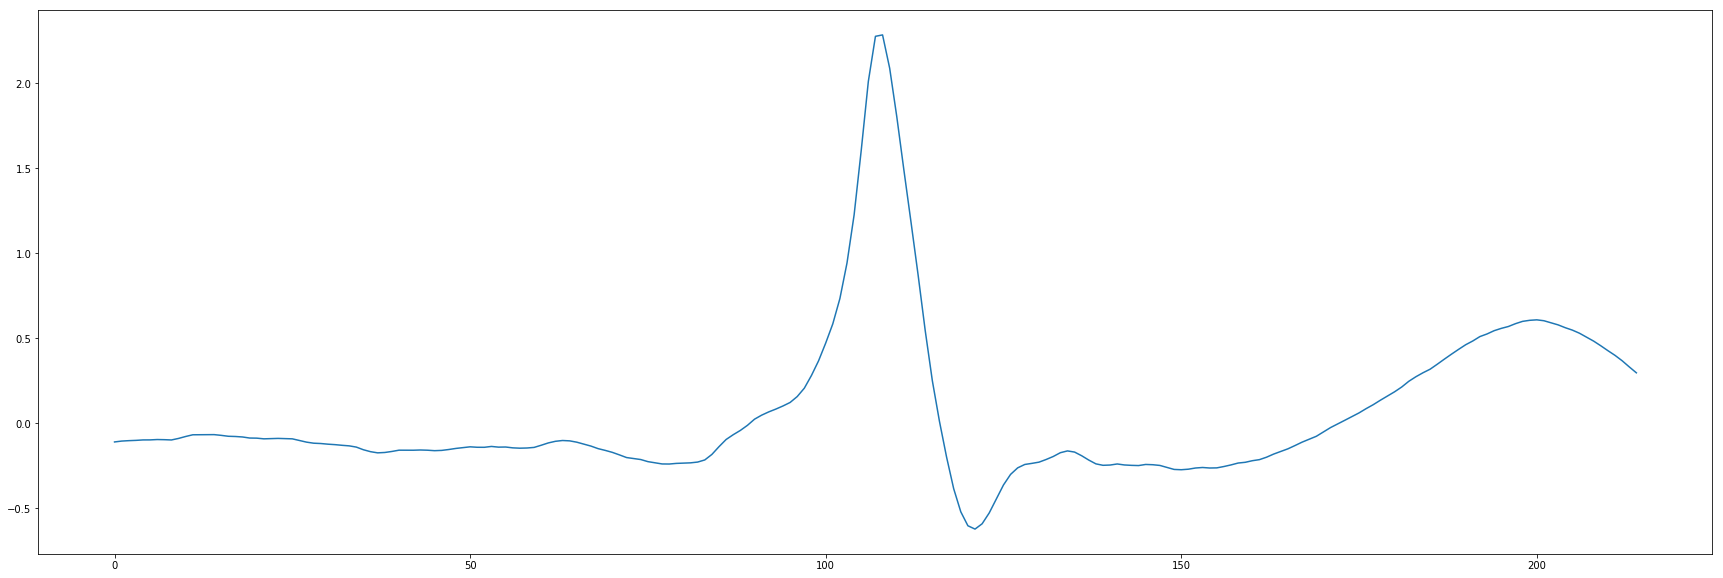

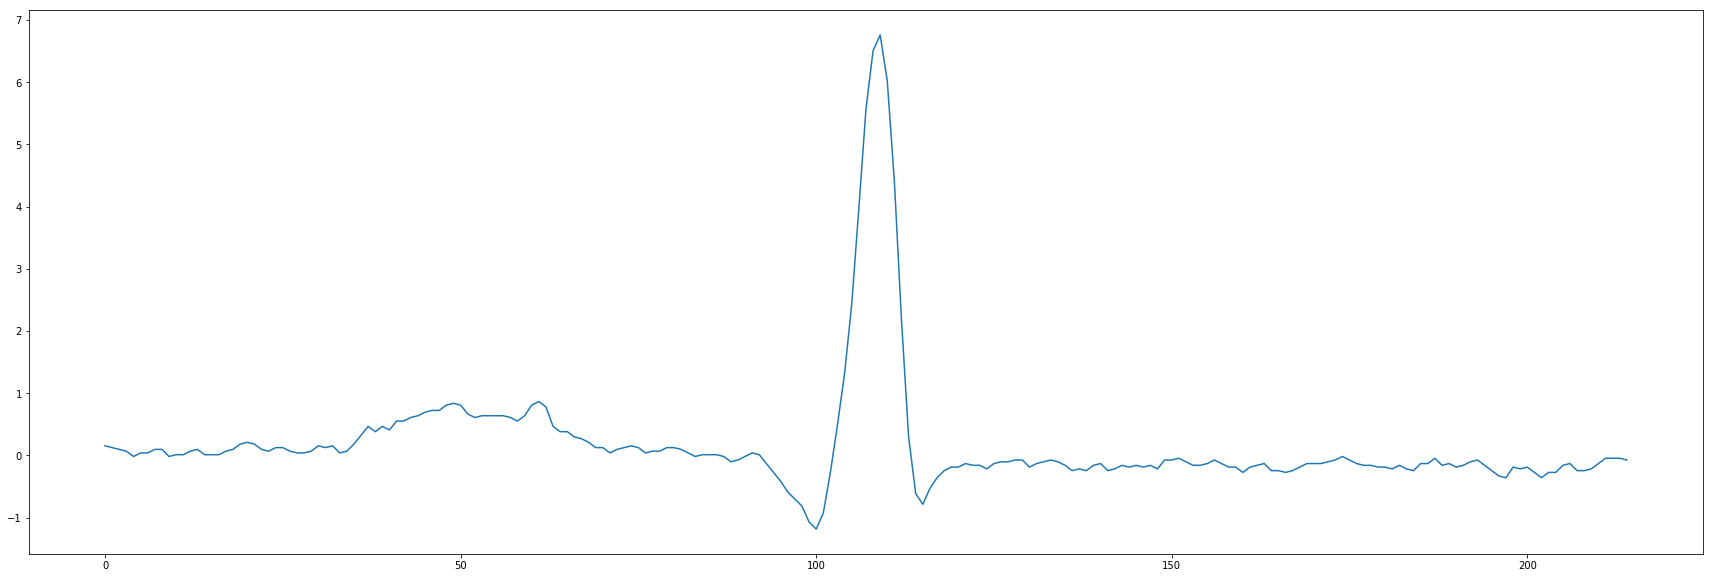

In [96]:
nrry=np.array(nrry)
arry=np.array(arry)

tarry=np.concatenate((arry, arry, arry, arry, arry))
tnrry=np.concatenate((nrry, nrry, nrry, nrry, nrry))

LR = LinearRegression()

X_fit, X_eval, y_fit, y_eval= TTS(normalt1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using raw first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(fnormalt1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using transformed first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coefn1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coeff1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of transformed first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(alln, tnrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all raw inputs is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(allf, tnrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all transformed input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coefn, tnrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all raw input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coeff, tnrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all transformed input is: '+str(c))



Using the separated beats and features from part A above, we try using the one versus all classifier to classify different beats.

In [95]:
Counter(arry)

Counter({'N': 11479,
         'A': 228,
         '/': 979,
         'f': 146,
         'V': 1016,
         'Q': 5,
         'L': 1059,
         'F': 169,
         'a': 7,
         'J': 1,
         'R': 1209,
         'e': 2})

1) Demean and scale, 2) subsample normal data to match classes, 3) cross-validate the right way, 4) Use PCA weights instead